In [1]:
!pip install -q underthesea
!pip install -q rouge-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Create a VQA Model using CNN and LSTM

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import AdamW
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, ViTFeatureExtractor, AutoModel, CLIPImageProcessor, AutoTokenizer, AutoImageProcessor, ViTModel
from transformers import BlipProcessor, BlipForConditionalGeneration
from datasets import load_dataset
from datasets import load_dataset, Features, Value
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
import os
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
from underthesea import word_tokenize, text_normalize
import re
import string
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 1
MAX_LEN = 100
EPOCHS = 2

2025-05-10 09:06:23.786260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746867983.995040      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746867984.053399      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data visulization

In [3]:
root_dir = "/kaggle/input/data-nlp-bai-2/data"
data_1 = pd.read_csv(f"{root_dir}/data_1.csv")
data_2 = pd.read_csv(f"{root_dir}/data_2.csv")
data_3 = pd.read_csv(f"{root_dir}/data_3.csv")
data_4 = pd.read_csv(f"{root_dir}/data_4.csv")
data_5 = pd.read_csv(f"{root_dir}/data_5.csv")
data_6 = pd.read_csv(f"{root_dir}/data_6.csv")
data_7 = pd.read_csv(f"{root_dir}/data_7.csv")
data_8 = pd.read_csv(f"{root_dir}/data_8.csv")
data_9 = pd.read_csv(f"{root_dir}/data_9.csv")
df_1 = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9])

In [4]:
root_dir = '/kaggle/input/data-nlp-bai-2/img/img'
df = df_1.copy()
# df = df.iloc[0:10000]
df = df.rename({"image_path": "image_id"}, axis = 1)
df["image_path"] = df['image_id'].apply(lambda x: os.path.join(root_dir, x))
df["image_id"] = df["image_id"].str.split(".").str[0]
df = df.dropna(subset=['question','answer']).copy()
df['question'] = df['question'].astype(str)
df['answer'] = df['answer'].astype(str)
df.drop(['description'], axis = 1, inplace = True)
df.reset_index(inplace=True)
df

index image_id                                           question  \
0           0        0          Cuốn sách trong ảnh thuộc bộ môn học nào?   
1           1        0               Cuốn sách dành cho học sinh lớp nào?   
2           2        0                     Cuốn sách được in lần thứ mấy?   
3           3        0  Ai là người chủ biên phần tiếng Việt của cuốn ...   
4           4        0                  Cuốn sách do đơn vị nào xuất bản?   
...       ...      ...                                                ...   
259089  19091    51855                    Câu hỏi 1 đề cập đến vấn đề gì?   
259090  19092    51855  Câu hỏi 2 đề cập đến các biện pháp bảo vệ dữ l...   
259091  19093    51855             Hình ảnh minh họa cho câu hỏi 1 là gì?   
259092  19094    51855  Hình ảnh minh họa cho phần bài tập vận dụng là...   
259093  19095    51855    Phần bài tập vận dụng yêu cầu người đọc làm gì?   

                                                   answer  \
0               Cuốn sách trong ảnh thuộc bộ môn Ngữ văn.   
1                     Cuốn sách dành cho học sinh lớp 12.   
2                           Cuốn sách được in lần thứ ba.   
3       Bùi Minh Toàn là người chủ biên phần tiếng Việ...   
4       Cuốn sách được xuất bản bởi Nhà xuất bản Giáo ...   
...                                                   ...   
259089  Câu hỏi 1 đề cập đến khả năng lưu trữ văn bản ...   
259090  Câu hỏi 2 đề cập đến 5 biện pháp bảo vệ dữ liệ...   
259091  Hình ảnh minh họa cho câu hỏi 1 là 4 khung tho...   
259092  Hình ảnh minh họa cho phần bài tập vận dụng là...   
259093  Phần bài tập vận dụng yêu cầu người đọc nêu bi...   

                                            image_path  
0           /kaggle/input/data-nlp-bai-2/img/img/0.jpg  
1           /kaggle/input/data-nlp-bai-2/img/img/0.jpg  
2           /kaggle/input/data-nlp-bai-2/img/img/0.jpg  
3           /kaggle/input/data-nlp-bai-2/img/img/0.jpg  
4           /kaggle/input/data-nlp-bai-2/img/img/0.jpg  
...                                                ...  
259089  /kaggle/input/data-nlp-bai-2/img/img/51855.jpg  
259090  /kaggle/input/data-nlp-bai-2/img/img/51855.jpg  
259091  /kaggle/input/data-nlp-bai-2/img/img/51855.jpg  
259092  /kaggle/input/data-nlp-bai-2/img/img/51855.jpg  
259093  /kaggle/input/data-nlp-bai-2/img/img/51855.jpg  

[259094 rows x 5 columns]

In [5]:
df = df[df['image_path'] != '/kaggle/input/data-nlp-bai-2/img/img/6803.jpg']
df = df[df['image_path'] != '/kaggle/input/data-nlp-bai-2/img/img/6801.jpg']
df[df["image_id"] == "6803"]

Empty DataFrame
Columns: [index, image_id, question, answer, image_path]
Index: []

In [6]:
df[df["image_id"] == "6801"]

Empty DataFrame
Columns: [index, image_id, question, answer, image_path]
Index: []

In [7]:
def normalize_text(text):
    clean_text = text.lower()

    replacements = {
        "nxb": "nhà xuất bản",
    }

    for old, new in replacements.items():
        clean_text = clean_text.replace(old, new)

    # Xóa ký tự đặc biệt VD (&nbsp;)
    clean_text = re.sub(r'&\S+;', ' ', clean_text)

    # Xóa emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)
    clean_text = re.sub(emoji_pattern, " ", clean_text)

    # Xóa ký tự đặc biệt không gõ được
    special_chars = ["“", "”", "…", "•", "–", "’", " ️", "✅", "✓", " ̂́ ̃ ̣̂ ", "‘", "●", "‒", "➤",
                     "★", "ღ", "✪", "‎", "➦", "×", "", "✿", "☆", "◤", "◕", "❁", "‿",
                     "❀", "■", "█", "☛", "⑴⒪⑵⑵⑴⑺", "►", "°", "»", "ø", "➽", "", "✧", "✽", "*",
                     "➫", "【", "】", "⇒", "卐", "♛", "±", "∞", "②", "⑥", "①", "⑦", "➋", "➊", "➌",
                     "✓", "™", "®", "", ""]
    for char in special_chars:
        clean_text = clean_text.replace(char, " ")

    # Bỏ các ký tự đặc biệt (dấu câu)
    clean_text = ''.join(' ' if char in string.punctuation else char for char in clean_text)

    # Loại bỏ khoảng trắng thừa
    clean_text = re.sub(r"\s+", " ", clean_text)
    clean_text = re.sub(r"^[\s]", "", clean_text)
    clean_text = re.sub(r"[\s]$", "", clean_text)

    # Đảm bảo dấu ở đúng chữ (ví dụ: oà, uý)
    clean_text = text_normalize(clean_text)

    # Tách câu thành từ
    clean_text = word_tokenize(clean_text, format="text")

    return clean_text

def apply_normalize_text_to_dataframe(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: normalize_text(str(x)))
    return df

In [8]:
columns_to_process = ['question', 'answer']
df = apply_normalize_text_to_dataframe(df, columns_to_process)
df

index image_id                                           question  \
0           0        0           cuốn sách trong ảnh thuộc bộ_môn_học nào   
1           1        0                cuốn sách dành cho học_sinh lớp nào   
2           2        0                      cuốn sách được in lần thứ mấy   
3           3        0  ai là người chủ biên_phần tiếng việt của cuốn ...   
4           4        0                   cuốn sách do đơn_vị nào xuất_bản   
...       ...      ...                                                ...   
259089  19091    51855                     câu hỏi 1 đề_cập đến vấn_đề gì   
259090  19092    51855  câu hỏi 2 đề_cập đến các biện_pháp bảo_vệ dữ_l...   
259091  19093    51855              hình_ảnh minh_họa cho câu hỏi 1 là gì   
259092  19094    51855  hình_ảnh minh_họa cho phần bài_tập vận_dụng là gì   
259093  19095    51855     phần bài_tập vận_dụng yêu_cầu người đọc làm gì   

                                                   answer  \
0                cuốn sách trong ảnh thuộc bộ_môn_ngữ văn   
1                      cuốn sách dành cho học_sinh lớp 12   
2                            cuốn sách được in lần thứ ba   
3       bùi_minh toàn là người chủ biên_phần tiếng việ...   
4       cuốn sách được xuất_bản bởi nhà_xuất_bản giáo_...   
...                                                   ...   
259089  câu hỏi 1 đề_cập đến khả_năng lưu_trữ văn_bản ...   
259090  câu hỏi 2 đề_cập đến 5 biện_pháp bảo_vệ dữ_liệ...   
259091  hình_ảnh minh_họa cho câu hỏi 1 là 4 khung_tho...   
259092  hình_ảnh minh_họa cho phần bài_tập vận_dụng là...   
259093  phần bài_tập vận_dụng yêu_cầu người đọc nêu bi...   

                                            image_path  
0           /kaggle/input/data-nlp-bai-2/img/img/0.jpg  
1           /kaggle/input/data-nlp-bai-2/img/img/0.jpg  
2           /kaggle/input/data-nlp-bai-2/img/img/0.jpg  
3           /kaggle/input/data-nlp-bai-2/img/img/0.jpg  
4           /kaggle/input/data-nlp-bai-2/img/img/0.jpg  
...                                                ...  
259089  /kaggle/input/data-nlp-bai-2/img/img/51855.jpg  
259090  /kaggle/input/data-nlp-bai-2/img/img/51855.jpg  
259091  /kaggle/input/data-nlp-bai-2/img/img/51855.jpg  
259092  /kaggle/input/data-nlp-bai-2/img/img/51855.jpg  
259093  /kaggle/input/data-nlp-bai-2/img/img/51855.jpg  

[259084 rows x 5 columns]

# Data visualization

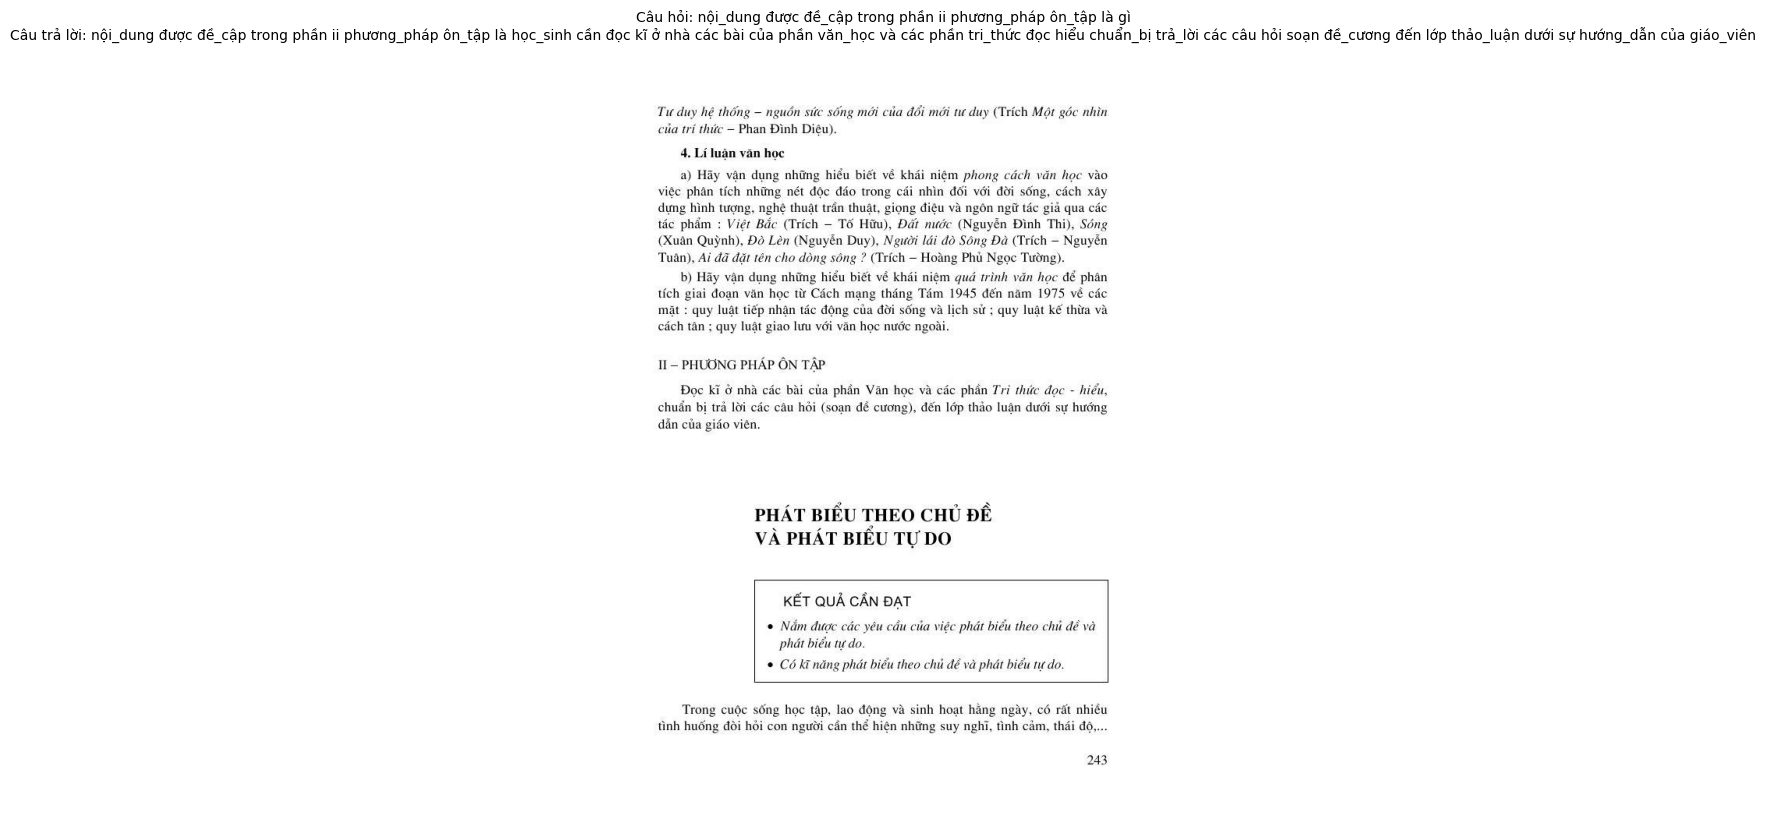

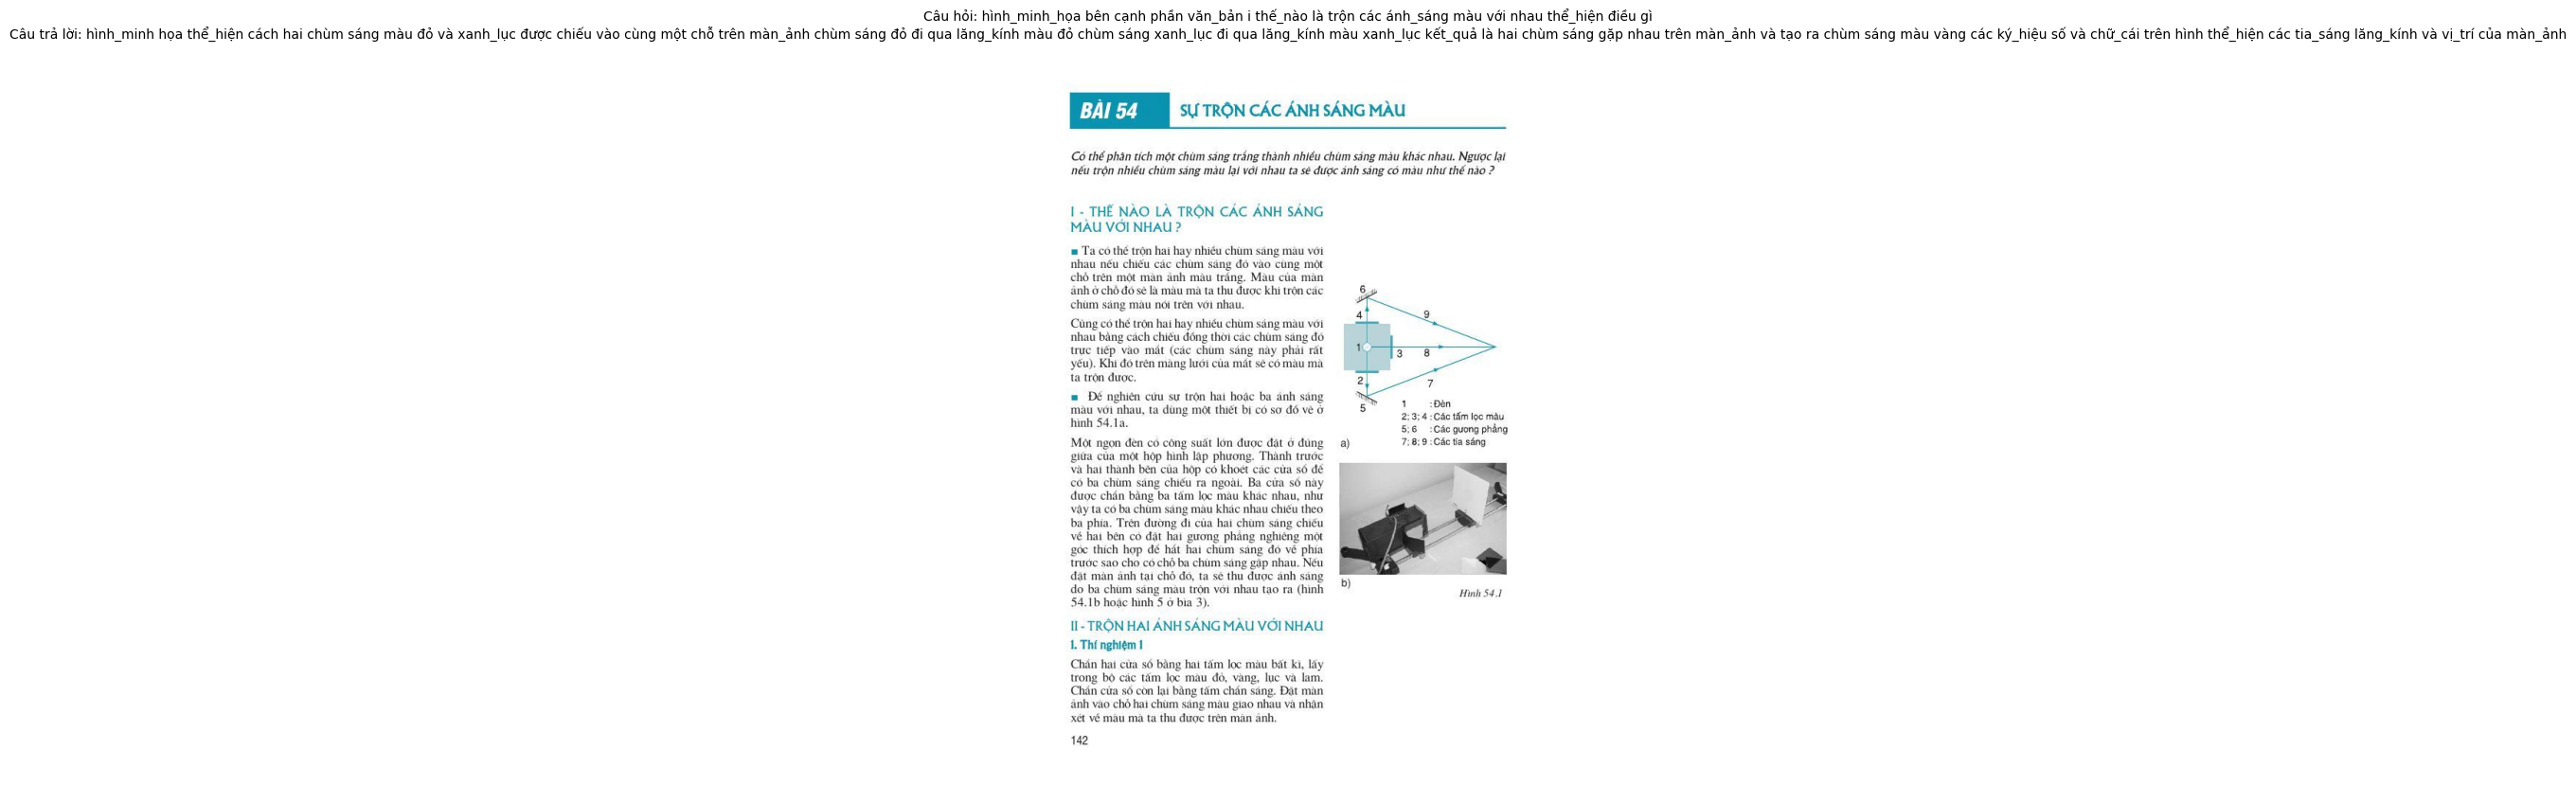

In [9]:
samples = df.sample(n=random.randint(2, min(2, len(df)))).reset_index(drop=True)

for i, row in samples.iterrows():
    image = row['image_path']
    question = row['question']
    answer = row['answer']

    try:
        # Mở và hiển thị hình ảnh
        img = Image.open(image)

        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Câu hỏi: {question}\nCâu trả lời: {answer}", fontsize=10)
        plt.axis('off')  # Ẩn trục để hiển thị gọn gàng hơn
        plt.show()
    except FileNotFoundError:
        print(f"Không tìm thấy hình ảnh: {image}")
    except Exception as e:
        print(f"Lỗi khi tải hình ảnh {image}: {e}")

In [10]:
def get_sentence_length(text):
    if not isinstance(text, str):
        return 0
    tokens = word_tokenize(text)
    return len(tokens)

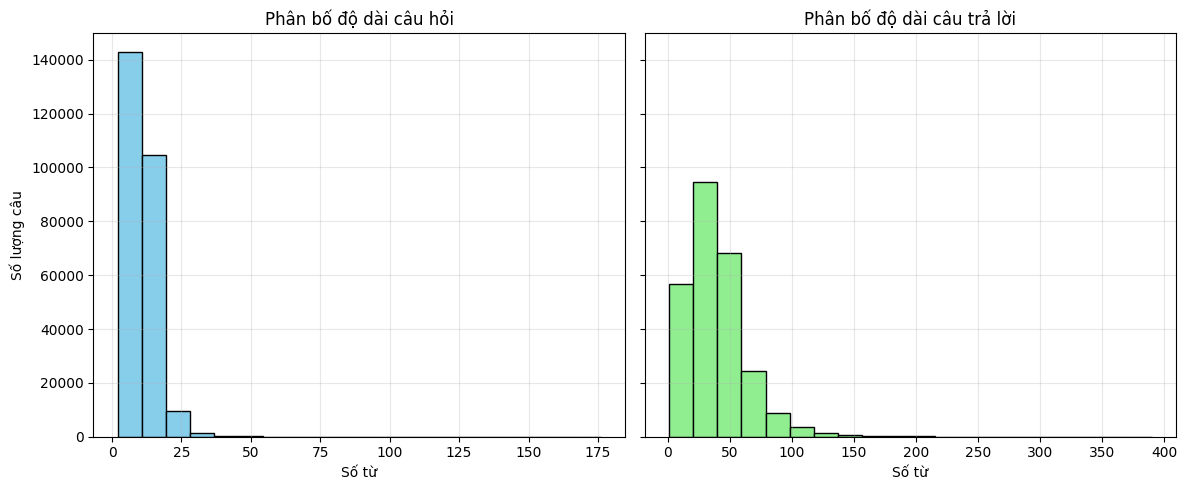

In [11]:
question_lengths = df['question'].apply(get_sentence_length).tolist()
answer_lengths = df['answer'].apply(get_sentence_length).tolist()

# Thiết lập bố cục subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Biểu đồ 1: Độ dài câu hỏi
ax1.hist(question_lengths, bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Phân bố độ dài câu hỏi')
ax1.set_xlabel('Số từ')
ax1.set_ylabel('Số lượng câu')
ax1.grid(True, alpha=0.3)

# Biểu đồ 2: Độ dài câu trả lời
ax2.hist(answer_lengths, bins=20, color='lightgreen', edgecolor='black')
ax2.set_title('Phân bố độ dài câu trả lời')
ax2.set_xlabel('Số từ')
ax2.grid(True, alpha=0.3)

# Tùy chỉnh khoảng cách giữa các subplot
plt.tight_layout()

In [12]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    return word_tokenize(text, format="text")

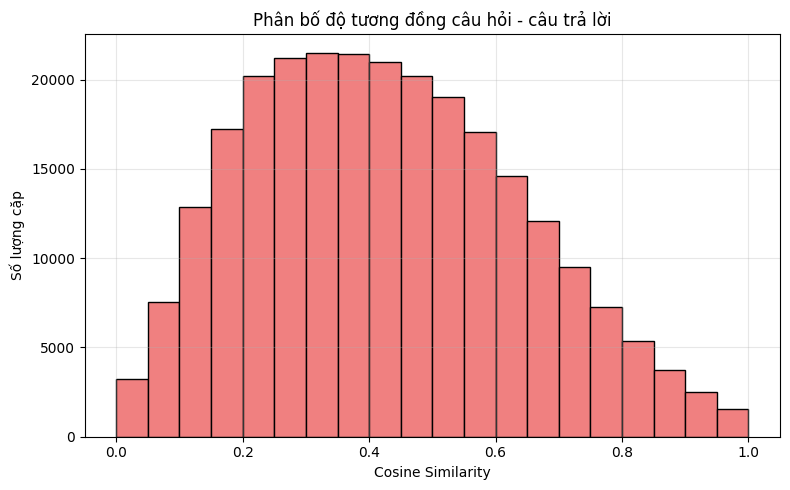

In [13]:
# Tính độ tương đồng cosine
# Chuẩn hóa văn bản cho TF-IDF
questions_preprocessed = df['question'].apply(preprocess_text).tolist()
answers_preprocessed = df['answer'].apply(preprocess_text).tolist()

# Kết hợp câu hỏi và câu trả lời để tạo TF-IDF vector
corpus = questions_preprocessed + answers_preprocessed
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Tách TF-IDF matrix thành phần cho câu hỏi và câu trả lời
question_tfidf = tfidf_matrix[:len(questions_preprocessed)]
answer_tfidf = tfidf_matrix[len(questions_preprocessed):]

# Tính cosine similarity cho từng cặp câu hỏi-câu trả lời
similarities = [cosine_similarity(question_tfidf[i], answer_tfidf[i])[0][0] for i in range(len(questions_preprocessed))]

# Vẽ biểu đồ histogram cho độ tương đồng
plt.figure(figsize=(8, 5))
plt.hist(similarities, bins=20, color='lightcoral', edgecolor='black')
plt.title('Phân bố độ tương đồng câu hỏi - câu trả lời')
plt.xlabel('Cosine Similarity')
plt.ylabel('Số lượng cặp')
plt.grid(True, alpha=0.3)

# Tùy chỉnh bố cục
plt.tight_layout()

# Add data gen

In [14]:
root_dir = "/kaggle/input/data-generative/Data_genarative"
df_list = []

for file_name in os.listdir(root_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(root_dir, file_name)
        try:
            df_gen = pd.read_csv(file_path)
            df_list.append(df_gen)
            print(f"Đã đọc file: {file_name}")
        except Exception as e:
            print(f"Lỗi khi đọc file {file_name}: {e}")

df_gen1 = pd.concat(df_list, ignore_index=True)

Đã đọc file: new_data_3.csv
Đã đọc file: new_data_2.csv
Đã đọc file: new_data_1.csv
Đã đọc file: new_data_5.csv
Đã đọc file: new_data_7.csv
Đã đọc file: new_data_6.csv
Đã đọc file: new_data_8.csv
Đã đọc file: new_data_4.csv


In [15]:
root_dir = '/kaggle/input/data-nlp-bai-2/img/img'
df_gen1 = df_gen1.rename({"image_path": "image_id"}, axis = 1)
df_gen1["image_path"] = df_gen1['image_id'].apply(lambda x: os.path.join(root_dir, x))
df_gen1["image_id"] = df_gen1["image_id"].str.split(".").str[0]
df_gen1 = df_gen1.dropna(subset=['question','answer']).copy()
df_gen1['question'] = df_gen1['question'].astype(str)
df_gen1['answer'] = df_gen1['answer'].astype(str)
df_gen1.drop(['description'], axis = 1, inplace = True)
df_gen1.reset_index(inplace=True)
df_gen1

index image_id                                           question  \
0          0     1052  Tác phẩm văn học có sự thay đổi ý nghĩa theo d...   
1          1     1052  Nội dung văn bản có nói về việc ý nghĩa của cá...   
2          2     1053  Định lý 2 cho biết công thức nào để tìm số hạn...   
3          3     1053  Số hạng tổng quát của cấp số cộng được tính to...   
4          4     1053  Định lý 2 được chứng minh bằng cách sử dụng kỹ...   
...      ...      ...                                                ...   
21206  21227     2001  Nội dung chính của ý thứ ba trong phần trình b...   
21207  21228     2001  Điểm tương đồng giữa hình 1 và hình 2 trong ản...   
21208  21229     2001  Hai hình ảnh số 1 và số 2 trong bức ảnh có đặc...   
21209  21230     2001        Điểm khác nhau giữa hình 1 và hình 2 là gì?   
21210  21231     2001           Hình 1 khác hình 2 ở những chi tiết nào?   

                                                  answer  \
0      Văn bản đề cập đến sự biến đổi của ý nghĩa tác...   
1      Văn bản đề cập đến sự biến đổi của ý nghĩa tác...   
2      Theo định lý 2, số hạng tổng quát của một cấp ...   
3      Theo định lý 2, số hạng tổng quát của một cấp ...   
4      Phương pháp quy nạp được sử dụng để chứng minh...   
...                                                  ...   
21206  Ý thứ 3 đề cập đến các cách sắp xếp hình mang,...   
21207  Cả hai hình đều sử dụng hình chữ nhật làm hình...   
21208  Cả hai hình đều sử dụng hình chữ nhật làm hình...   
21209  Hình 1 sử dụng hình chữ nhật kết hợp với các h...   
21210  Hình 1 sử dụng hình chữ nhật kết hợp với các h...   

                                          image_path  
0      /kaggle/input/data-nlp-bai-2/img/img/1052.jpg  
1      /kaggle/input/data-nlp-bai-2/img/img/1052.jpg  
2      /kaggle/input/data-nlp-bai-2/img/img/1053.jpg  
3      /kaggle/input/data-nlp-bai-2/img/img/1053.jpg  
4      /kaggle/input/data-nlp-bai-2/img/img/1053.jpg  
...                                              ...  
21206  /kaggle/input/data-nlp-bai-2/img/img/2001.jpg  
21207  /kaggle/input/data-nlp-bai-2/img/img/2001.jpg  
21208  /kaggle/input/data-nlp-bai-2/img/img/2001.jpg  
21209  /kaggle/input/data-nlp-bai-2/img/img/2001.jpg  
21210  /kaggle/input/data-nlp-bai-2/img/img/2001.jpg  

[21211 rows x 5 columns]

In [16]:
columns_to_process = ['question', 'answer']
df_gen1 = apply_normalize_text_to_dataframe(df_gen1, columns_to_process)
df_gen1

index image_id                                           question  \
0          0     1052  tác_phẩm văn_học có sự thay_đổi ý_nghĩa theo d...   
1          1     1052  nội_dung văn_bản có nói về việc ý_nghĩa của cá...   
2          2     1053  định_lý 2 cho biết công_thức nào để tìm số hạn...   
3          3     1053  số hạng tổng_quát của cấp số cộng được tính_to...   
4          4     1053  định_lý 2 được chứng_minh bằng cách sử_dụng kỹ...   
...      ...      ...                                                ...   
21206  21227     2001  nội_dung chính của ý thứ ba trong phần trình_b...   
21207  21228     2001  điểm tương_đồng giữa hình 1 và hình 2 trong ản...   
21208  21229     2001  hai hình_ảnh số 1 và số 2 trong bức ảnh có đặc...   
21209  21230     2001         điểm khác nhau giữa hình 1 và hình 2 là gì   
21210  21231     2001            hình 1 khác hình 2 ở những chi_tiết nào   

                                                  answer  \
0      văn_bản đề_cập đến sự biến_đổi của ý_nghĩa tác...   
1      văn_bản đề_cập đến sự biến_đổi của ý_nghĩa tác...   
2      theo định_lý 2 số hạng tổng_quát của một cấp s...   
3      theo định_lý 2 số hạng tổng_quát của một cấp s...   
4      phương_pháp quy_nạp được sử_dụng để chứng_minh...   
...                                                  ...   
21206  ý thứ 3 đề_cập đến các cách sắp_xếp hình mang ...   
21207  cả hai hình đều sử_dụng hình_chữ_nhật làm hình...   
21208  cả hai hình đều sử_dụng hình_chữ_nhật làm hình...   
21209  hình 1 sử_dụng hình_chữ_nhật kết_hợp với các h...   
21210  hình 1 sử_dụng hình_chữ_nhật kết_hợp với các h...   

                                          image_path  
0      /kaggle/input/data-nlp-bai-2/img/img/1052.jpg  
1      /kaggle/input/data-nlp-bai-2/img/img/1052.jpg  
2      /kaggle/input/data-nlp-bai-2/img/img/1053.jpg  
3      /kaggle/input/data-nlp-bai-2/img/img/1053.jpg  
4      /kaggle/input/data-nlp-bai-2/img/img/1053.jpg  
...                                              ...  
21206  /kaggle/input/data-nlp-bai-2/img/img/2001.jpg  
21207  /kaggle/input/data-nlp-bai-2/img/img/2001.jpg  
21208  /kaggle/input/data-nlp-bai-2/img/img/2001.jpg  
21209  /kaggle/input/data-nlp-bai-2/img/img/2001.jpg  
21210  /kaggle/input/data-nlp-bai-2/img/img/2001.jpg  

[21211 rows x 5 columns]

In [17]:
df_1 = df.copy()
df_gen_2 = df_gen1.copy()

In [18]:
df = pd.concat([df_1, df_gen_2], ignore_index=True)

df = df.sort_values(by=['image_path', 'answer'], ignore_index=True)
df.drop_duplicates(inplace=True, ignore_index=True)
df.drop(["index"], axis = 1, inplace = True)
df.reset_index(inplace=True)
new_columns = ["index",'image_id', "image_path", 'question', 'answer']
df = df[new_columns]
df

index image_id                                     image_path  \
0            0        0     /kaggle/input/data-nlp-bai-2/img/img/0.jpg   
1            1        0     /kaggle/input/data-nlp-bai-2/img/img/0.jpg   
2            2        0     /kaggle/input/data-nlp-bai-2/img/img/0.jpg   
3            3        0     /kaggle/input/data-nlp-bai-2/img/img/0.jpg   
4            4        0     /kaggle/input/data-nlp-bai-2/img/img/0.jpg   
...        ...      ...                                            ...   
280290  280290     9998  /kaggle/input/data-nlp-bai-2/img/img/9998.jpg   
280291  280291     9999  /kaggle/input/data-nlp-bai-2/img/img/9999.jpg   
280292  280292     9999  /kaggle/input/data-nlp-bai-2/img/img/9999.jpg   
280293  280293     9999  /kaggle/input/data-nlp-bai-2/img/img/9999.jpg   
280294  280294     9999  /kaggle/input/data-nlp-bai-2/img/img/9999.jpg   

                                                 question  \
0       ai là người chủ biên_phần tiếng việt của cuốn ...   
1       ai là người chịu trách_nhiệm biên_soạn nội_dun...   
2       người nào đóng vai_trò chủ_chốt trong việc biê...   
3                     cuốn sách dành cho học_sinh lớp nào   
4               sách này phù_hợp với trình_độ học_vấn nào   
...                                                   ...   
280290  điều gì đã xảy ra với a_ri_ôn trong cuộc phiêu...   
280291  hình 29 1 a và hình 29 1 trong ảnh minh_họa ch...   
280292  quá_trình nguyên_phân được chia thành mấy kỳ v...   
280293  cơ_chế của việc hai nhiễm sắc_thể đơn phân_li ...   
280294  sự co_rút của sợi thoi phân_bào được mô_tả như...   

                                                   answer  
0       bùi_minh toàn là người chủ biên_phần tiếng việ...  
1       bùi_minh toàn là người chủ biên_phần tiếng việ...  
2       bùi_minh toàn là người chủ biên_phần tiếng việ...  
3                      cuốn sách dành cho học_sinh lớp 12  
4                      cuốn sách dành cho học_sinh lớp 12  
...                                                   ...  
280290  trong một cuộc thi ca_hát ở đảo xi xin a_ri_ôn...  
280291  hình 29 1 a_minh họa cho sự phân_chia nhân tro...  
280292  quá_trình nguyên_phân được chia thành 4 kỳ_kỳ ...  
280293  sự co_rút của sợi thoi phân_bào kéo hai nhiễm ...  
280294  sự co_rút của sợi thoi phân_bào được mô_tả như...  

[280295 rows x 5 columns]

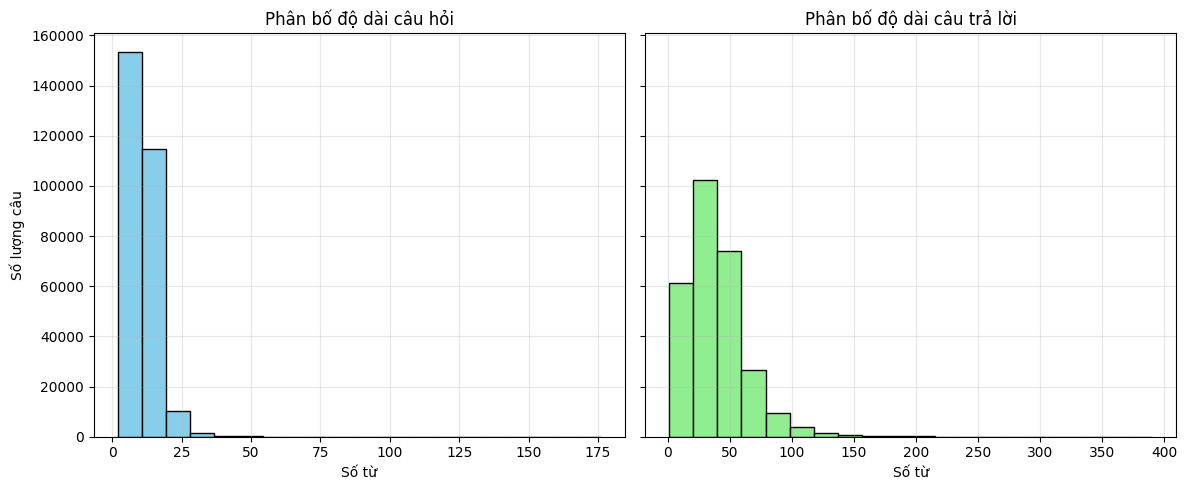

In [19]:
question_lengths = df['question'].apply(get_sentence_length).tolist()
answer_lengths = df['answer'].apply(get_sentence_length).tolist()

# Thiết lập bố cục subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Biểu đồ 1: Độ dài câu hỏi
ax1.hist(question_lengths, bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Phân bố độ dài câu hỏi')
ax1.set_xlabel('Số từ')
ax1.set_ylabel('Số lượng câu')
ax1.grid(True, alpha=0.3)

# Biểu đồ 2: Độ dài câu trả lời
ax2.hist(answer_lengths, bins=20, color='lightgreen', edgecolor='black')
ax2.set_title('Phân bố độ dài câu trả lời')
ax2.set_xlabel('Số từ')
ax2.grid(True, alpha=0.3)

# Tùy chỉnh khoảng cách giữa các subplot
plt.tight_layout()

In [20]:
def preprocess_text(text):
    # Chuyển thành chữ thường
    text = text.lower()
    # Loại bỏ dấu câu
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    # Thay dấu '_' bằng khoảng trắng
    text = text.replace('_', ' ')
    # Tokenize bằng underthesea
    text = word_tokenize(text, format="text")
    return text

In [21]:
def calculate_similarity(questions):
    if len(questions) < 2:
        return []  # Không tính nếu chỉ có 1 câu hỏi
    
    # Tiền xử lý các câu hỏi
    processed_questions = [preprocess_text(q) for q in questions]
    
    # Vector hóa bằng TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(processed_questions)
    
    # Tính độ tương đồng cosine
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # Lưu kết quả cho từng cặp câu hỏi
    similarities = []
    for i in range(len(questions)):
        for j in range(i + 1, len(questions)):
            similarities.append({
                'question_1': questions[i],
                'question_2': questions[j],
                'similarity': similarity_matrix[i][j]
            })
    
    return similarities

In [22]:
grouped = df.groupby('answer')

# Lưu kết quả độ tương đồng
all_similarities = []

# Duyệt qua từng nhóm có cùng 'answer'
for answer, group in grouped:
    if len(group) > 1:  # Chỉ xét các nhóm có từ 2 câu hỏi trở lên
        questions = group['question'].tolist()
        similarities = calculate_similarity(questions)
        for sim in similarities:
            sim['answer'] = answer  # Gắn câu trả lời vào kết quả
            all_similarities.append(sim)

# Chuyển kết quả thành DataFrame
similarity_df = pd.DataFrame(all_similarities)

# Sắp xếp theo độ tương đồng (giảm dần)
# similarity_df = similarity_df.sort_values(by='similarity', ascending=False)

In [23]:
similarity_df

question_1  \
0      trong ví_dụ minh_họa về hệ đếm cơ_số 16 số 1 d...   
1      trong ví_dụ minh_họa về hệ đếm cơ_số 16 số 1 d...   
2      giá_trị thập_phân tương_ứng với số 1 d2b trong...   
3      trong ví_dụ minh_họa về hệ đếm cơ_số 8 số 16 4...   
4      trong ví_dụ minh_họa về hệ đếm cơ_số 8 số 16 4...   
...                                                  ...   
46687  hãy giải_thích vai_trò của ứng_động đối_với đờ...   
46688  ứng_động có ý_nghĩa như_thế_nào đối_với sự sốn...   
46689  ứng_động là gì hãy nêu hai loại ứng_động_cơ_bả...   
46690  ứng_động là gì hãy nêu hai loại ứng_động_cơ_bả...   
46691                     ứng_động được hiểu như_thế_nào   

                                              question_2  similarity  \
0      giá_trị thập_phân tương_ứng với số 1 d2b trong...    0.127470   
1      số 1 d2b hệ 16 có giá_trị tương_đương bao_nhiê...    0.376175   
2      số 1 d2b hệ 16 có giá_trị tương_đương bao_nhiê...    0.389798   
3      quy_trình chuyển_đổi số 16453 từ hệ bát phân s...    0.155051   
4      phương_pháp tính giá_trị thập_phân tương_ứng c...    0.187893   
...                                                  ...         ...   
46687  tầm quan_trọng của ứng_động thể_hiện ở những k...    0.209019   
46688  tầm quan_trọng của ứng_động thể_hiện ở những k...    0.120751   
46689                     ứng_động được hiểu như_thế_nào    0.063798   
46690   thực_vật có những hình_thức ứng_động chủ_yếu nào    0.127468   
46691   thực_vật có những hình_thức ứng_động chủ_yếu nào    0.078296   

                                                  answer  
0      1 d2b cơ_số 16 1 16 3 13 16 2 2 16 1 11 16 0 7...  
1      1 d2b cơ_số 16 1 16 3 13 16 2 2 16 1 11 16 0 7...  
2      1 d2b cơ_số 16 1 16 3 13 16 2 2 16 1 11 16 0 7...  
3      16 453 cơ_số 8 1 8 4 6 8 3 4 8 2 5 8 1 3 8 0 7...  
4      16 453 cơ_số 8 1 8 4 6 8 3 4 8 2 5 8 1 3 8 0 7...  
...                                                  ...  
46687  ứng_động giúp thực_vật thích_nghi với môi_trườ...  
46688  ứng_động giúp thực_vật thích_nghi với môi_trườ...  
46689  ứng_động là phản_ứng của thực_vật trước tác_nh...  
46690  ứng_động là phản_ứng của thực_vật trước tác_nh...  
46691  ứng_động là phản_ứng của thực_vật trước tác_nh...  

[46692 rows x 4 columns]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


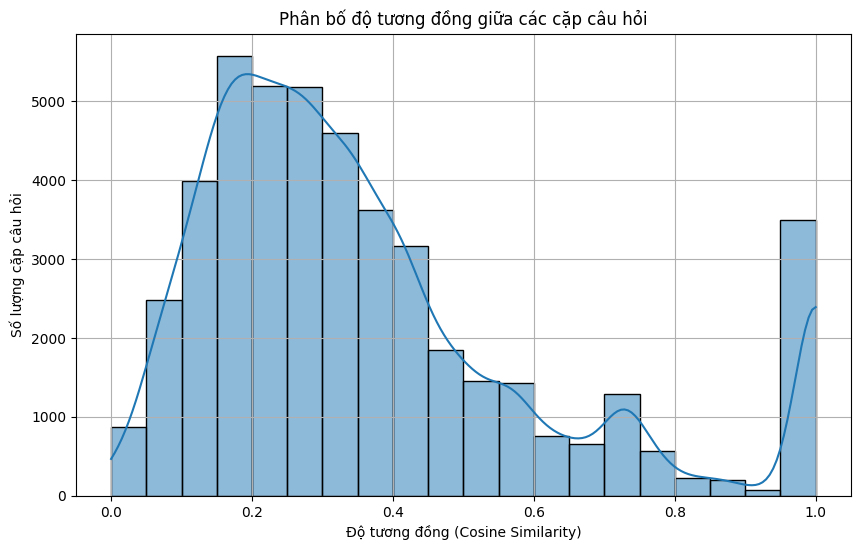

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(similarity_df['similarity'], bins=20, kde=True)
plt.title('Phân bố độ tương đồng giữa các cặp câu hỏi')
plt.xlabel('Độ tương đồng (Cosine Similarity)')
plt.ylabel('Số lượng cặp câu hỏi')
plt.grid(True)
plt.savefig('similarity_histogram.png')
plt.show()

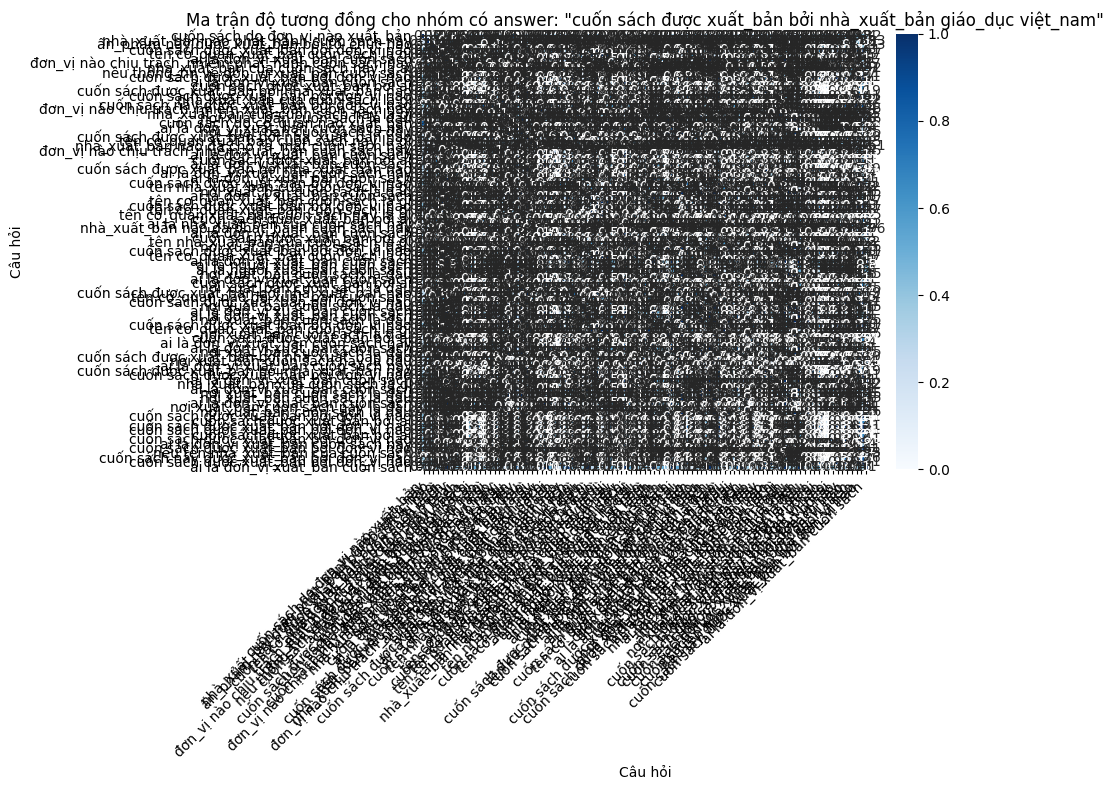

In [25]:
max_group = grouped.size().idxmax()
group = grouped.get_group(max_group)
questions = group['question'].tolist()

if len(questions) > 1:
    processed_questions = [preprocess_text(q) for q in questions]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(processed_questions)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap='Blues', xticklabels=questions, yticklabels=questions)
    plt.title(f'Ma trận độ tương đồng cho nhóm có answer: "{max_group}"')
    plt.xlabel('Câu hỏi')
    plt.ylabel('Câu hỏi')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('similarity_heatmap.png')
    plt.show()
else:
    print(f"Nhóm có answer '{max_group}' chỉ có 1 câu hỏi, không vẽ heatmap.")

# Tokenize


In [26]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
vocab = tokenizer.get_vocab()
len(vocab)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

64001

# Train test split

In [27]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Kiểm tra kích thước
print("Number of rows in train set:", len(df_train))
print("Number of rows in test set:", len(df_test))
print("Train set columns:", df_train.columns)
print("Test set columns:", df_test.columns)

Number of rows in train set: 224236
Number of rows in test set: 56059
Train set columns: Index(['index', 'image_id', 'image_path', 'question', 'answer'], dtype='object')
Test set columns: Index(['index', 'image_id', 'image_path', 'question', 'answer'], dtype='object')


In [28]:
df_train.head()

index image_id                                      image_path  \
151153  151153    34699  /kaggle/input/data-nlp-bai-2/img/img/34699.jpg   
141682  141682    33025  /kaggle/input/data-nlp-bai-2/img/img/33025.jpg   
51492    51492    17724  /kaggle/input/data-nlp-bai-2/img/img/17724.jpg   
148236  148236    34181  /kaggle/input/data-nlp-bai-2/img/img/34181.jpg   
209625  209625    45023  /kaggle/input/data-nlp-bai-2/img/img/45023.jpg   

                                                 question  \
151153  hai hình_ảnh minh_họa cho hai hành_tinh_kepler...   
141682  hình 1 mô_tả cấu_tạo của động_cơ không đồng_bộ...   
51492   bức ảnh mô_tả bao_nhiêu loại khối khí liệt_kê ...   
148236                                ảnh có hình_ảnh nào   
209625  ngoài việc đọc bài thơ còn những cách nào khác...   

                                                   answer  
151153  hình_ảnh minh_họa cho hai hành_tinh_kepler 186...  
141682  hình 1 mô_tả cấu_tạo của động_cơ không đồng_bộ...  
51492   bức ảnh mô_tả bốn loại khối khí chính_cực a ôn...  
148236      ảnh chỉ có nội_dung văn_bản không có hình_ảnh  
209625  văn_bản không đề_cập đến những cách_thức khác ...

In [29]:
df_test.head()

index image_id                                      image_path  \
240052  240052     5040   /kaggle/input/data-nlp-bai-2/img/img/5040.jpg   
2193      2193     1032   /kaggle/input/data-nlp-bai-2/img/img/1032.jpg   
174855  174855    38888  /kaggle/input/data-nlp-bai-2/img/img/38888.jpg   
196432  196432    42696  /kaggle/input/data-nlp-bai-2/img/img/42696.jpg   
250447  250447      551    /kaggle/input/data-nlp-bai-2/img/img/551.jpg   

                                                 question  \
240052  nội_dung trong phần 2 1 đề_cập đến điều gì câu...   
2193           nhảy xa kiểu ngồi được chia thành mấy bước   
174855  tại_sao có những xung_đột và nội_chiến giữa cá...   
196432  hãy dự_đoán hiện_tượng xảy ra khi thay nước xà...   
250447  đâu là lý_do khiến tác_giả nhấn_mạnh tính kinh...   

                                                   answer  
240052  phần 2 1 dẫn lời bài hát dân_gian việt_nam muờ...  
2193    kỹ_thuật nhảy xa kiểu ngồi gồm 6 giai_đoạn chạ...  
174855  theo tài_liệu xung_đột và nội_chiến giữa các p...  
196432  khi thay nước xà_phòng bằng nước bột giặt tron...  
250447  tác_giả khẳng_định việc tập_thể_dục không tốn_...

# Change form to dataset

In [30]:
class VQA_dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anno_id, img_id, image_path, question, answer = self.data.iloc[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return anno_id, img_id, image, question, answer

In [31]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),

    #Thêm 1 vài bước xử lý ảnh để đa dạng hóa dữ liệu - Data Augmentation
    transforms.RandomRotation(30),  # Xoay ảnh ngẫu nhiên trong khoảng ±30 độ
    # transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Điều chỉnh độ sáng, độ tương phản
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

train_dataset = VQA_dataset(df, transform=transform)
test_dataset = VQA_dataset(df_test, transform=transform)

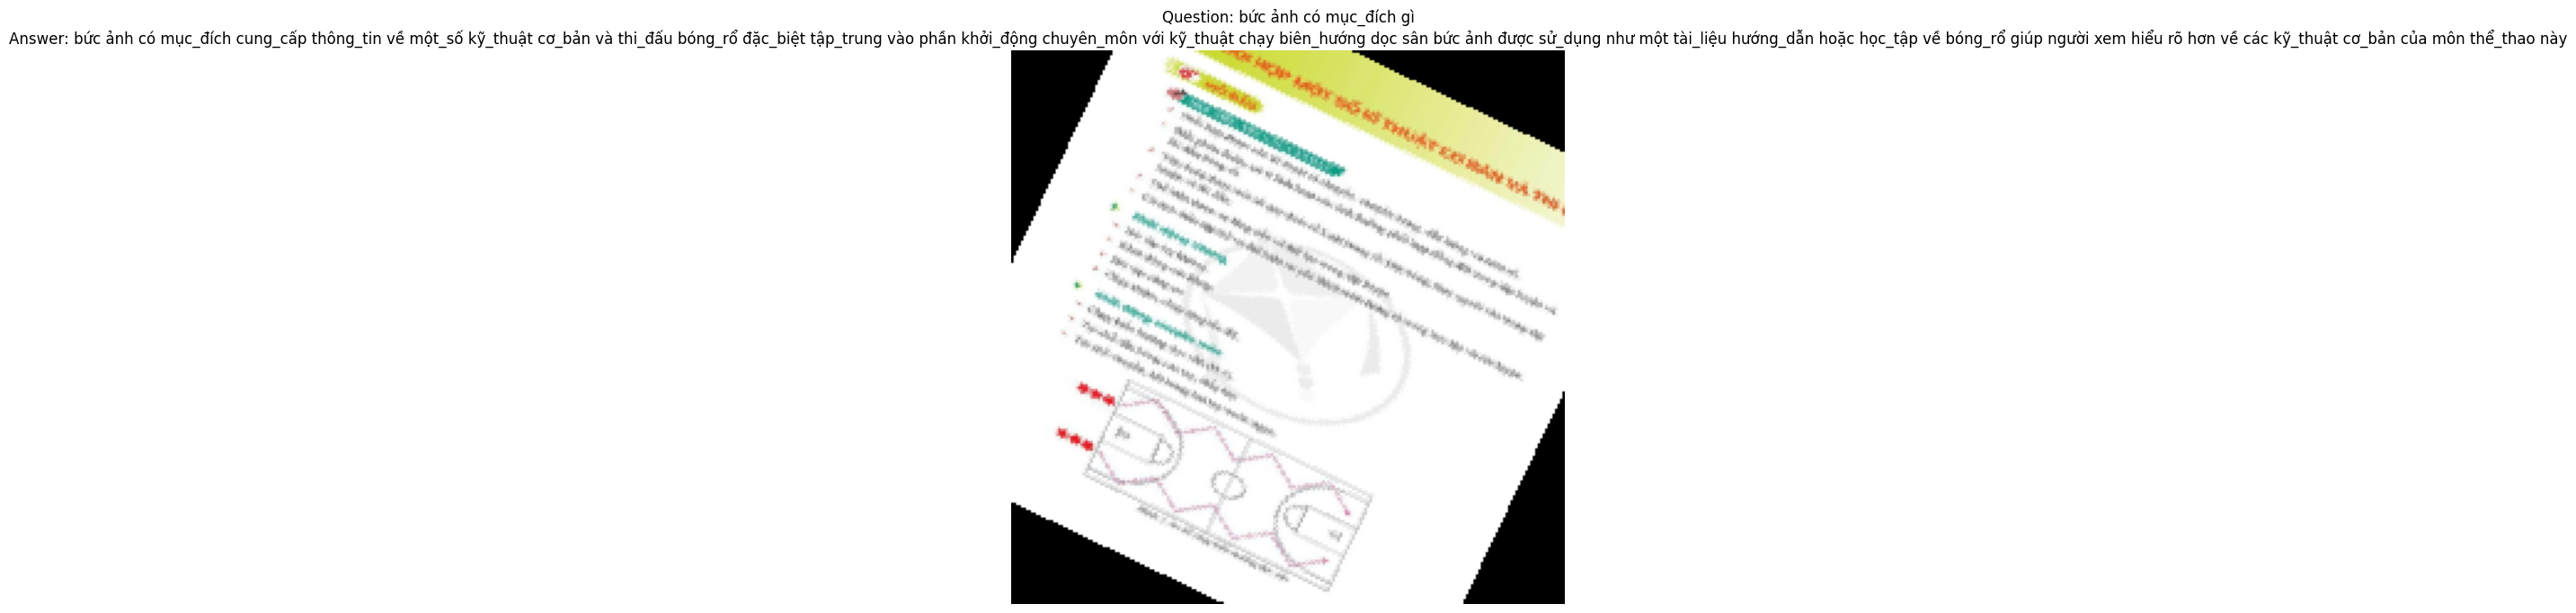

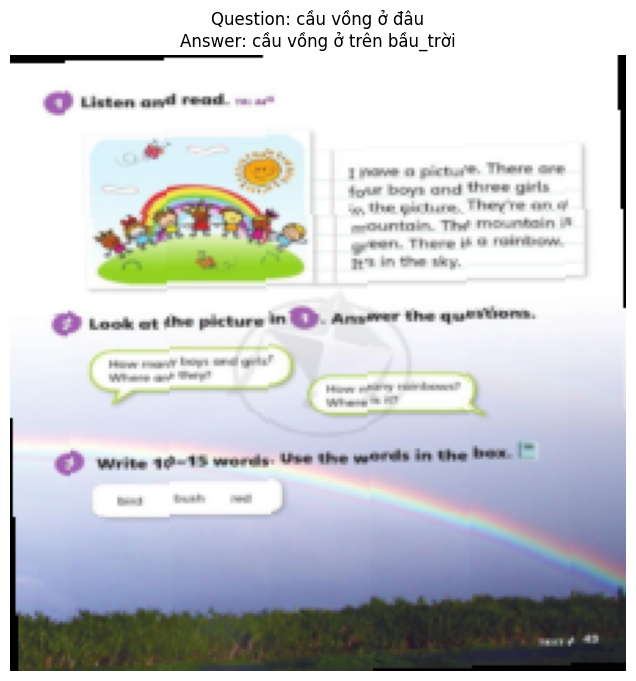

In [32]:
random_indices = np.random.choice(len(train_dataset), 2)

for idx in random_indices:
    anno_id, img_id, image, question, answer = train_dataset[idx]
    
    image = image.permute(1, 2, 0).numpy()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title("Question: " + question + "\nAnswer: " + answer)
    plt.axis('off')
    plt.show()

In [33]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
len(train_loader), len(test_loader)

(17519, 56059)

In [34]:
anno_id, img_id, image, quesiton, answer = next(enumerate(train_loader))[1]
len(answer), len(image), len(quesiton)

(16, 16, 16)

# Using Pretrain for VQA

In [35]:
image_model_name = "google/vit-base-patch16-224-in21k"
class ImageEmbedding(nn.Module):
    def __init__(self):
        super(ImageEmbedding, self).__init__()
        self.process = AutoImageProcessor.from_pretrained(image_model_name)
        self.model = ViTModel.from_pretrained(image_model_name)
        #self.model = nn.Sequential(*list(self.model.children())[:3])
        
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, image, image_ids):
        inputs = self.process(image, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs.to(device))
            
        image_embedding = outputs.last_hidden_state
        return image_embedding, image_ids

In [36]:
text_model_name = "vinai/phobert-base"
class QuesEmbedding(nn.Module):
    def __init__(self, input_size=768, output_size=768):
        super(QuesEmbedding, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(text_model_name)
        self.phobert = AutoModel.from_pretrained(text_model_name)
        self.lstm = nn.LSTM(input_size, output_size, batch_first=True)

    def forward(self, ques):
        tokenized_input = self.tokenizer(ques, 
                                         return_tensors='pt', 
                                         padding='max_length', 
                                         max_length=MAX_LEN, 
                                         truncation=True, 
                                         add_special_tokens=False)
        ques = self.phobert(**tokenized_input.to(device)).last_hidden_state
        _, (h, _) = self.lstm(ques)
        return h.squeeze(0)

## Test Batch

In [37]:
image_model = ImageEmbedding().to(device)
ques_model = QuesEmbedding().to(device)

for batch in train_loader:
    anno_ids, img_ids, images, questions, answers = batch
    if torch.cuda.is_available():
        images = images.cuda()
        questions = questions
        anno_ids = anno_ids
    
    with torch.no_grad():
        image_embeddings, att_ids = image_model(images, image_ids=anno_ids)
        ques_embeddings = ques_model(questions)
    break    

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [38]:
print(image_embeddings.size())
print(att_ids.size())
print(ques_embeddings.size())

torch.Size([16, 197, 768])
torch.Size([16])
torch.Size([16, 768])


In [39]:
image_embeddings = image_embeddings.reshape(TRAIN_BATCH_SIZE, 768, -1).permute(0, 2, 1)
ques_embeddings = ques_embeddings.unsqueeze(1)
print(image_embeddings.size())
print(ques_embeddings.size())

torch.Size([16, 197, 768])
torch.Size([16, 1, 768])


# Stack Attention Networks

In [40]:
#Linear để giảm kích thước, không cần tile repeat mà đưa vào san để nhân luôn cuối cùng trả về vector attention mà ko cần phải flatten
class StackAttention(nn.Module):
    def __init__(self, d=768, k=512, dropout=True):
        super(StackAttention, self).__init__()
        self.ff_image = nn.Linear(d, k)
        self.ff_ques = nn.Linear(d, k)
        if dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.ff_attention = nn.Linear(k, 1)

    def forward(self, vi, vq):
        # N * 49 * 768 -> N * 49 * 512
        hi = self.ff_image(vi)
        #print("hi size: ", hi.size())
        # N * 768 -> N * 512 -> N * 1 * 512
        hq = self.ff_ques(vq)
        #print("hq size: ", hq.size())
        # N * 49 * 512
        ha = F.tanh(hi + hq)
        #print("ha1 size: ", ha.size())
        if getattr(self, 'dropout'):
            ha = self.dropout(ha)
        #DONE
        
        # N * 49 * 512 -> N * 49 * 1 -> N * 49
        ha = self.ff_attention(ha).squeeze(dim=2)
        #print("ha2 size: ", ha.size())
        pi = F.softmax(ha)
        # (N * 49 * 1, N * 49 * 768) -> N * 768
        vi_attended = (pi.unsqueeze(dim=2) * vi).sum(dim=1)
        #print("vi~ size: ", vi_attended.size())
        #print("vq size: ", vq.size())
        u = vi_attended + vq.squeeze(1)
        return u

In [41]:
san_model = StackAttention(d=768, k=512, dropout=True).to(device)
img_text_att = san_model(image_embeddings.to(device), ques_embeddings.to(device))
img_text_att.size()

/tmp/ipykernel_19/2416429134.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(ha)


torch.Size([16, 768])

# Generate Answer

## Answers Embedding

In [42]:
class AnsEmbedding(nn.Module):
    def __init__(self, input_size=768):
        super(AnsEmbedding, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(text_model_name)
        self.phobert_embed = AutoModel.from_pretrained(text_model_name).embeddings.to(device)

    def forward(self, ans):  
        tokenized_input = self.tokenizer(ans, 
                                         return_tensors='pt',
                                         padding='max_length', 
                                         max_length=MAX_LEN, 
                                         truncation=True, return_attention_mask=False)
        ans = self.phobert_embed(**tokenized_input.to(device))
        return tokenized_input['input_ids'], ans

In [43]:
ans_model = AnsEmbedding().to(device)

for batch in train_loader:
    anno_id, img_id, images, questions, answers = batch
    if torch.cuda.is_available():
        answers = answers
    with torch.no_grad():
        ans_tokens, answers_embedding = ans_model(answers)
    break   
ans_tokens.size(), answers_embedding.size() 

(torch.Size([16, 100]), torch.Size([16, 100, 768]))

In [44]:
print(answers_embedding.size())
print(img_text_att.size())

torch.Size([16, 100, 768])
torch.Size([16, 768])


## Decoder

In [45]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1] 
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) 
    if mask is not None:
        scaled += mask 
    attention = F.softmax(scaled, dim=-1) 
    values = torch.matmul(attention, v)
    return values, attention


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x) 
        x = self.linear2(x)
        return x


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape)) # 512
        self.beta =  nn.Parameter(torch.zeros(parameters_shape)) # 512

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))] # [-1]
        mean = inputs.mean(dim=dims, keepdim=True) 
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt() 
        y = (inputs - mean) / std 
        out = self.gamma * y  + self.beta  
        return out

class MaskMultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model) 
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size() 
        qkv = self.qkv_layer(x) 
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) 
        q, k, v = qkv.chunk(3, dim=-1) 
        values, attention = scaled_dot_product(q, k, v, mask) 
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim) 
        out = self.linear_layer(values) # 30 x 200 x 512
        return out # 30 x 200 x 512


class MultiHeadCrossAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model) # 1024
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y, mask=None):
        batch_size, sequence_length, d_model = x.size()
        kv = self.kv_layer(x) 
        q = self.q_layer(y) 
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim) 
        kv = kv.permute(0, 2, 1, 3) 
        q = q.permute(0, 2, 1, 3) 
        k, v = kv.chunk(2, dim=-1) 
        values, attention = scaled_dot_product(q, k, v, mask) 
        values = values.reshape(batch_size, sequence_length, d_model) 
        out = self.linear_layer(values)
        return out  


class DecoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MaskMultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, decoder_mask):
        _y = y
        y = self.self_attention(y, mask=decoder_mask)
        y = self.dropout1(y)
        y = self.norm1(y + _y)

        _y = y # 30 x 200 x 512
        y = self.encoder_decoder_attention(x, y, mask=None)
        y = self.dropout2(y)
        y = self.norm2(y + _y)

        _y = y 
        y = self.ffn(y) 
        y = self.dropout3(y)
        y = self.norm3(y + _y) 
        return y 

class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, mask = inputs
        for module in self._modules.values():
            y = module(x, y, mask)
        return y

class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers=1):
        super().__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) 
                                          for _ in range(num_layers)])

    def forward(self, x, y, mask):
        y = self.layers(x, y, mask)
        return y

In [46]:
d_model = 768
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = MAX_LEN
ffn_hidden = 2048
num_layers = 5

x = img_text_att.unsqueeze(1).expand(-1, max_sequence_length, -1).to(device) # 16 * 768 -> 16 * 48 * 1024
y = answers_embedding.to(device) #16 * 48 * 768
mask = torch.full([max_sequence_length, max_sequence_length] , float('-inf'))
mask = torch.triu(mask, diagonal=1).to(device)
decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers).to(device)
out = decoder(x, y, mask).to(device)

In [47]:
vocab_size = len(vocab)

linear_layer = nn.Linear(d_model, vocab_size).to(device)
output_logits = linear_layer(out)
output_probs = F.softmax(output_logits, dim=2)
output_probs.size()

torch.Size([16, 100, 64001])

In [48]:
from transformers import PhobertTokenizer
tokenizer = PhobertTokenizer.from_pretrained("vinai/phobert-base")

decoder_output = output_probs
predicted_tokens = decoder_output.argmax(dim=2)

def tokens_to_text(tokens, tokenizeFcr):
    return [tokenizer.decode(token.item()) for token in tokens]

for i in range(16):
    generated_text = tokens_to_text(predicted_tokens[i], tokenizer)
    print(f"Generated text for example {i}: {' '.join(generated_text)}")

Generated text for example 0: Phúc_Yên 60kg chỉn_chu bèo_bọt tối_mịt Lucas@@ o-@@ mệ ib@@ Hộ@@ Nhiếp_ảnh trưởng_thôn 27.000 eo ớt_hải lão_luyện quay_@@ Hương_Khê Bea@@ cá_voi hát_bội Arcti@@ Mahrez nút Houthi nhất_@@ HUY X-quang T-Mobile HUY trông_đợi Giáo_dục_@@ ban_bố Barba@@ vàng_ròng フ@@ ích_lô Paran@@ lợi_dụng uyên_ương Dưa_@@ fus@@ CC@@ 天@@ virút Asen@@ Lý_Thường_@@ ký XD iên_th@@ khát_vọng Dragons Đặng_@@ Mahrez tico cảm_ứng Stoke Ối pha_trò nhắc_nhở 500 nhắc_nhở nhắc_nhở nhắc_nhở khuyên_can Central_Group nhắc_nhở Central_Group Central_Group Central_Group nhắc_nhở Central_Group khuyên_can nhắc_nhở Patri@@ Newton khe_@@ khe_@@ 老@@ cực_đoan khe_@@ khe_@@ nhắc_nhở khe_@@ hư_@@ khe_@@ nhắc_nhở nhắc_nhở khuyên_can nhắc_nhở nhắc_nhở nhắc_nhở nhắc_nhở CĐ nhắc_nhở nhắc_nhở nhắc_nhở CĐ House nhắc_nhở
Generated text for example 1: Gamuda_@@ DL Lê_Quốc_Phong vì_thế Thomis@@ Hyundai bắt_nạt L-@@ Royal@@ mất_mạng xương_chậu gấp_rút úc_t@@ isa Madrid Lúc_nào Networks Bãi_@@ ellidae Montpelli@

# VQA Model

In [49]:
class VQAModel(nn.Module):

    def __init__(self, vocab_size=64001, output_size=768, d_model=768, num_head=8, ffn_hidden=2048, drop_prob=0.3, num_layers=6, num_att_layers=4, mode='train'):
        super(VQAModel, self).__init__()
        self.mode = mode
        self.image_model = ImageEmbedding().to(device)
        self.ques_model = QuesEmbedding().to(device)
        self.ans_model = AnsEmbedding().to(device)
        
        self.san_model = nn.ModuleList(
            [StackAttention(d=d_model, k=512, dropout=True)] * num_att_layers).to(device)
        
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers).to(device)
        
        self.mlp = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(d_model, vocab_size))

    def forward(self, images, questions, answers, anno_ids, mask, mode, max_len=MAX_LEN):
        image_embeddings, att_ids = self.image_model(images.to(device), image_ids=anno_ids)
        if mode == 'train':
            image_embedds = image_embeddings.reshape(TRAIN_BATCH_SIZE, 768, -1).permute(0, 2, 1)
        else:
            image_embedds = image_embeddings.reshape(VAL_BATCH_SIZE, 768, -1).permute(0, 2, 1)
        
        ques_embeddings = self.ques_model(questions)
        ques_embedds = ques_embeddings.unsqueeze(1)
        
        for att_layer in self.san_model:
            att_embedds = att_layer(image_embedds.to(device), ques_embedds.to(device))
        
        att_embedds = self.tanh(att_embedds)
        att_embedds = self.dropout(att_embedds)
        
        #START DECODER
        ans_vocab, ans_embedds = self.ans_model(answers)
        
        x = att_embedds.to(device).unsqueeze(1).expand(-1, max_len, -1).to(device) # 16 * 768 -> 16 * 48 * 768
        y = ans_embedds # 16 * 48 * 768
        #print(x)
        #print(y.size())
        if mask == False:
            out = self.decoder(x, y, mask=None).to(device)
        else:
            mask = torch.full([max_len, max_len] , float('-inf'))
            mask = torch.triu(mask, diagonal=1).to(device)
        
            out = self.decoder(x, y, mask).to(device)
        #END DECODER
        #print(out)
        output_logits = self.mlp(out)
        return output_logits, ans_vocab

# Train

In [50]:
model = VQAModel().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=1)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [51]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 286,348,290 trainable parameters.


In [52]:
vocab_swap = {value: key for key, value in vocab.items()}

In [53]:
num_epochs = EPOCHS
print_every = 500

losses = []
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train() 
    total_loss = 0.0
    for batch_idx, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=False):
        anno_id, img_id, images, questions, answers = batch
        if len(images) == TRAIN_BATCH_SIZE:
            predicted_tokens, ans_embedds = model(images.to(device), questions, answers, anno_id, mode='train', mask=True)
            predicted_tokens = predicted_tokens.float()
            ans_embedds = ans_embedds.long()
            
            for i in range(TRAIN_BATCH_SIZE):
                sentence_predicted = torch.argmax(predicted_tokens[i], axis=1)
                predicted_sentence = ""
                for idx in sentence_predicted:
                    predicted_sentence += vocab_swap[idx.item()] + " "
                    if idx == 2:
                        break
                if (batch_idx + 1) % print_every == 0:
                    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")
                    print(f"Question: {questions[i]}")
                    print(f"Answer: {answers[i]}")
                    print(f"Answer Prediction: {predicted_sentence}")
                    break
    
            loss = criterion(predicted_tokens.permute(0, 2, 1), ans_embedds)
            #valid_indicies = torch.where(ans_embedds == 1, False, True)
            #loss = loss.sum() / valid_indicies.sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            losses.append(loss.item())
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/2 (Train):   0%|          | 0/17519 [00:00<?, ?it/s]/tmp/ipykernel_19/2416429134.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(ha)

Epoch 1/2 (Train):   3%|▎         | 499/17519 [08:09<4:33:32,  1.04it/s]

Epoch [1/2], Batch [500/17519], Loss: 6.8063
Question: số 95 ở góc dưới bên phải có ý_nghĩa gì
Answer: số 95 là số trang của tài_liệu nó giúp người đọc xác_định được vị_trí của trang hiện_tại trong toàn_bộ tài_liệu
Answer Prediction: <s> số là là số một của </s> 



Epoch 1/2 (Train):   6%|▌         | 999/17519 [16:09<4:30:25,  1.02it/s]

Epoch [1/2], Batch [1000/17519], Loss: 5.2408
Question: nước nào có tỉ_lệ dân_số nam cao hơn nữ vào năm 1910
Answer: theo biểu_đồ hình_tháp dân_số nước đức có tỉ_lệ dân_số nam cao hơn nữ vào năm 1910
Answer Prediction: <s> theo <s> ảnh </s> 



Epoch 1/2 (Train):   9%|▊         | 1499/17519 [24:08<4:17:59,  1.03it/s]

Epoch [1/2], Batch [1500/17519], Loss: 4.2464
Question: hình minh_họa trong ảnh đại_diện cho điều gì
Answer: hình_minh họa là một chồng sách xếp chồng lên nhau hình_ảnh tượng_trưng cho việc đọc sách kiến_thức và việc học_hỏi từ những cuốn sách
Answer Prediction: <s> hình_@@ minh họ@@ a là một nhau sách và vào lên nhau hình_ảnh và cho việc đọc sách kiến_thức và việc học_sinh từ những </s> 



Epoch 1/2 (Train):  11%|█▏        | 1999/17519 [32:02<4:06:18,  1.05it/s]

Epoch [1/2], Batch [2000/17519], Loss: 3.4444
Question: mô_tả hình vẽ minh_họa trong phần 1 tính thể_tích của vật_thể
Answer: hình_vẽ là một minh_họa cho vật_thể trong không_gian 3 chiều vật_thể được giới_hạn bởi hai mặt_phẳng vuông_góc với trục ox tại các điểm có hoành_độ là a và b các thiết_diện của vật_thể cắt bởi các mặt_phẳng vuông_góc với trục ox được đánh_dấu màu xám_hình vẽ minh_họa cách tính thể_tích của vật_thể bằng_tích phân bằng cách chia vật_thể thành nhiều lát mỏng có diện_tích s x và độ dày_dx sau đó cộng các thể_tích của các lát này lại với nhau
Answer Prediction: <s> ảnh là một minh_@@ họ@@ a cho là trong đó 3 chiều <s> được đề_cập bởi hai mặt_phẳng trên với câu o@@ x ở các điểm có <unk> độ là a và b các <s> cao của khác cắt bởi các mặt_phẳng bài_tập với câu o@@ x được tạo màu </s> 



Epoch 1/2 (Train):  14%|█▍        | 2499/17519 [39:56<3:57:33,  1.05it/s]

Epoch [1/2], Batch [2500/17519], Loss: 3.0030
Question: trong bài_tập 2 của phần 4 b ai là người viết email
Answer: trong bài_tập 2 của phần 4 b người viết email là eva eva viết thư cho dì polly và kể về cuộc_sống của mình ở ngôi trường mới
Answer Prediction: <s> trong bài_tập 2 của phần 4 b người viết không là văn_bản còn viết minh_@@ cho bức </s> 



Epoch 1/2 (Train):  17%|█▋        | 2999/17519 [47:46<3:42:46,  1.09it/s]

Epoch [1/2], Batch [3000/17519], Loss: 3.0304
Question: pascal được phát_triển dựa trên ngôn_ngữ nào
Answer: pascal được phát_triển bởi niklaus wirth dựa trên ngôn_ngữ algol năm 1970
Answer Prediction: <s> giữa <s> được phát_triển bởi hình_ảnh h@@ h@@ ta đến họ@@ x dựa trên ngôn_ngữ của 3 l năm sub </s> 



Epoch 1/2 (Train):  20%|█▉        | 3499/17519 [55:34<3:42:06,  1.05it/s]

Epoch [1/2], Batch [3500/17519], Loss: 2.7540
Question: trong trò_chơi được minh_họa trong ảnh người chơi cần làm gì
Answer: trò_chơi được minh_họa trong ảnh là trò_chơi ai nhanh nhất người chơi sẽ cần di_chuyển theo sơ_đồ bắt_đầu từ một điểm cố_định và đi qua tất_cả các vòng_tròn màu đỏ và xanh sau đó về đích bên cạnh đó họ cần quan_sát vị_trí và thời_điểm bật_nhảy phù_hợp để đạt kết_quả tốt nhất
Answer Prediction: <s> trò_chơi được minh_@@ họ@@ a trong ảnh là trò_chơi ai nhanh nhất người chơi sẽ cần di_chuyển theo sơ_đồ bắt_đầu từ một điểm cố_định và đi qua tất_cả các vòng_tròn màu đỏ và xanh sau đó về 0 bên cạnh đó họ cần quan_sát vị_trí và khi <unk> đến phù_hợp để đạt kết_quả tốt nhất </s> 



Epoch 1/2 (Train):  23%|██▎       | 3999/17519 [1:03:20<3:32:05,  1.06it/s]

Epoch [1/2], Batch [4000/17519], Loss: 2.4286
Question: có bao_nhiêu tỉnh_thành được thể_hiện trên bản_đồ việt_nam
Answer: bản_đồ việt_nam thể_hiện 63 tỉnh_thành
Answer Prediction: <s> bản_đồ việt_@@ nam thể_hiện i văn_bản </s> 



Epoch 1/2 (Train):  26%|██▌       | 4499/17519 [1:11:03<3:17:36,  1.10it/s]

Epoch [1/2], Batch [4500/17519], Loss: 2.1446
Question: ngoài việc thực_hiện động_tác học_sinh cần chú_ý điều gì trong bài_học này
Answer: ngoài việc thực_hiện động_tác học_sinh cần chú_ý đến tinh_thần tự_chủ tích_cực đoàn_kết khi tham_gia tập_luyện và trò_chơi vận_động điều này giúp học_sinh rèn_luyện kỹ_năng giao_tiếp hợp_tác và xây_dựng tinh_thần đồng_đội trong hoạt_động tập_thể
Answer Prediction: <s> ngoài việc thực_hiện động_tác học_sinh cần chú_ý đến tinh_thần </s> 



Epoch 1/2 (Train):  29%|██▊       | 4999/17519 [1:18:46<3:11:03,  1.09it/s]

Epoch [1/2], Batch [5000/17519], Loss: 1.6398
Question: có những_ai tham_gia biên_soạn cuốn sách này
Answer: cuốn sách này được biên_soạn bởi trần nam_dũng tổng_chủ biên_khúc thành chính chủ_biên đinh_thị xuân_dung nguyễn_kinh_đức đinh_thị kim_lan và huỳnh_thị kim_trang
Answer Prediction: <s> cuốn sách này được biên_soạn bởi là nam_@@ một tổng_@@ chủ biên_@@ đoạn thành chính tác_giả d nh_th@@ minh họ@@ hoặc nguy@@ ễn_@@ tự_nhiên đức khó_khăn nh_th@@ x@@ phần lan và hu@@ cậu nh_th@@ những nền hình_@@ ang </s> 



Epoch 1/2 (Train):  31%|███▏      | 5499/17519 [1:26:26<3:03:30,  1.09it/s]

Epoch [1/2], Batch [5500/17519], Loss: 1.8370
Question: có hình_ảnh nào trong bức ảnh
Answer: bức ảnh chỉ chứa nội_dung văn_bản không có hình_ảnh
Answer Prediction: <s> bức ảnh chỉ chứa nội_dung văn_bản không có hình_ảnh </s> 



Epoch 1/2 (Train):  34%|███▍      | 5999/17519 [1:34:05<2:54:07,  1.10it/s]

Epoch [1/2], Batch [6000/17519], Loss: 2.0253
Question: dấu có ý_nghĩa gì trong ảnh
Answer: dấu có_thể là một ký_hiệu trang chỉ ra trang tiếp_theo trong một tài_liệu hoặc có_thể là một dấu_hiệu cho mục_đích khác mà không_thể xác_định được chỉ dựa vào bức ảnh
Answer Prediction: <s> dấu có_thể là một ký_hiệu trang chỉ ra trang tiếp_theo trong một tài_liệu hoặc có_thể là một biểu_hiện cho mục_đích khác mà không_thể xác_định được chỉ dựa vào bức ảnh </s> 



Epoch 1/2 (Train):  37%|███▋      | 6499/17519 [1:41:43<2:52:30,  1.06it/s]

Epoch [1/2], Batch [6500/17519], Loss: 1.7218
Question: theo bức ảnh người nói nên làm gì để nhận được phản_hồi tích_cực từ người nghe
Answer: theo bức ảnh người nói nên tiếp_nhận ý_kiến phản_hồi và trao_đổi với các thành_viên khác trong nhóm lớp với thái_độ cầu_thị bao_lưu hoặc tiếp_thu nếu phương_án sửa_chữa hoàn_thiện đồng_thời người nói cũng_nên đánh_giá được một_cách khách_quan toàn_diện về bài thuyết_trình có_thể tham_khảo các nội_dung đánh_giá trong bảng sau
Answer Prediction: <s> theo bức ảnh người nói nên t ý_kiến phản_ứng và trao_đổi với các thành_viên khác trong nhóm lớp với thái_độ <unk> ab@@ và hoặc tiếp_thu nếu phương_án sửa_chữa hoàn_thiện đồng_thời người nói làm_việc đánh_giá được một_cách bị nội_dung về bài thuyết_trình có_thể tham_khảo các nội_dung đánh_giá trong bảng sau </s> 



Epoch 1/2 (Train):  40%|███▉      | 6999/17519 [1:49:19<2:40:18,  1.09it/s]

Epoch [1/2], Batch [7000/17519], Loss: 2.1166
Question: câu hỏi a yêu_cầu người đọc làm gì
Answer: câu hỏi a yêu_cầu người đọc tìm những từ_ngữ trong bài thơ_tả hoa gió núi_đồi mặt_trời câu hỏi này giúp người đọc rèn_luyện kỹ_năng nhận_biết và phân_tích từ_ngữ trong văn_bản
Answer Prediction: <s> câu hỏi a yêu_cầu người đọc tìm những từ_ngữ trong bài thơ@@ _t@@ ảnh hoa gió it mặt_trời câu hỏi này giúp người đọc rèn_luyện kỹ_năng nhận_biết và phân_tích từ_ngữ trong văn_bản </s> 



Epoch 1/2 (Train):  43%|████▎     | 7499/17519 [1:56:54<2:36:44,  1.07it/s]

Epoch [1/2], Batch [7500/17519], Loss: 1.7002
Question: bài_tập 2 4 yêu_cầu gì
Answer: bài_tập 2 4 yêu_cầu học_sinh so_sánh hai giá_trị bằng phép_tính bình_phương ví_dụ ý_a học_sinh cần so_sánh 3 2 và 2 2 tương_tự ý b c d cũng yêu_cầu so_sánh hai giá_trị bằng bình_phương
Answer Prediction: <s> bài_tập 2 4 yêu_cầu học_sinh so_sánh hai giá_trị bằng phép_tính bình_@@ phương ví_dụ hô_hấp a học_sinh cần so_sánh 3 2 và 2 2 tương_tự ý b c d cũng yêu_cầu so_sánh hai giá_trị bằng bình_@@ phương </s> 



Epoch 1/2 (Train):  46%|████▌     | 7999/17519 [2:04:29<2:25:58,  1.09it/s]

Epoch [1/2], Batch [8000/17519], Loss: 1.4614
Question: trong đoạn văn_tác_giả đã sử_dụng những động từ nào để miêu_tả hành_động của dòng sông hãy giải_thích ý_nghĩa của những động từ đó trong ngữ cảnh
Answer: tác_giả sử_dụng nhiều động từ để miêu_tả hành_động của dòng sông tạo nên một bức tranh sinh_động về sự uyển_chuyển mạnh_mẽ và đầy ẩn_dụ của dòng_chảy một_số động từ tiêu_biểu bao_gồm bóp chặt miêu_tả dòng sông như một lực_lượng mạnh_mẽ dữ_dội bóp chặt lấy những vật_thể xung_quanh lùa vào miêu_tả dòng sông như một con thú săn mồi nhẹ_nhàng nhưng đầy uy_lực lùa những vật_thể vào lòng mình chạm lùa miêu_tả dòng sông như một con rắn nhẹ_nhàng uyển_chuyển chạm lùa vào những vật_thể bò trườn miêu_tả dòng sông như một con rắn chậm_rãi uyển_chuyển bò trườn qua những vật_thể nằm chờ miêu_tả dòng sông như một con thú săn mồi kiên_nhẫn chờ_đợi thời_cơ thích_hợp để tấn_công
Answer Prediction: <s> tác_giả sử_dụng nhiều động từ để miêu_tả hành_động của dòng sông tạo nên một bức tranh sinh_động


Epoch 1/2 (Train):  49%|████▊     | 8499/17519 [2:12:02<2:20:38,  1.07it/s]

Epoch [1/2], Batch [8500/17519], Loss: 1.4312
Question: bài_học này thuộc bài số bao_nhiêu
Answer: bài_học này thuộc bài số 34
Answer Prediction: <s> bài_học này thuộc bài số 34 </s> 



Epoch 1/2 (Train):  51%|█████▏    | 8999/17519 [2:19:36<2:07:10,  1.12it/s]

Epoch [1/2], Batch [9000/17519], Loss: 0.8523
Question: hình_ảnh minh_họa trong bức ảnh thể_hiện điều gì
Answer: hình_ảnh minh_họa cho thấy bạch_thái bưởi là người tiên_phong trong ngành vận_tải đường thủy ba con tàu được vẽ với kích_thước khác nhau thể_hiện sự phát_triển của ngành vận_tải đường thủy từ thời_kỳ đầu đến khi bạch_thái bưởi mở công_ty vận_tải của mình hình_ảnh chân_dung của bạch_thái bưởi được đặt trong một vòng_tròn cho thấy ông là nhân_vật chính trong câu_chuyện hình_ảnh minh_họa giúp người đọc hình_dung rõ nét hơn về ngành vận_tải đường thủy và vai_trò của bạch_thái bưởi trong ngành này
Answer Prediction: <s> hình_ảnh minh_@@ họ@@ a cho thấy và trình_bày ái ở là người em trong ngành vận_tải đường thủ@@ y ba con tàu được vẽ với kích_thước khác nhau thể_hiện sự phát_triển của ngành vận_tải đường thủ@@ y từ thời_kỳ đầu đến khi r trình_bày ái hãy mở công_ty vận_tải của mình hình_ảnh chân_dung của <unk> vuông ái tứ_giác được đặt trong một vòng_tròn cho thấy ông là nhân_vật 


Epoch 1/2 (Train):  54%|█████▍    | 9499/17519 [2:27:09<2:01:36,  1.10it/s]

Epoch [1/2], Batch [9500/17519], Loss: 0.9558
Question: mẫu đơn thư_chuyển_tiền được in trên giấy gì
Answer: mẫu đơn thư_chuyển_tiền được in trên giấy màu trắng có dòng chữ bưu_điện việt_nam dọc theo cạnh bên phải
Answer Prediction: <s> mẫu đơn thư_@@ do tăng_cường được in trên giấy màu trắng có dòng chữ cột việt_@@ nam dọc theo cạnh bên phải </s> 



Epoch 1/2 (Train):  57%|█████▋    | 9999/17519 [2:34:42<1:52:36,  1.11it/s]

Epoch [1/2], Batch [10000/17519], Loss: 0.7775
Question: số trang của bài_học thứ 6 là bao_nhiêu
Answer: bài_học thứ 6 có số trang là 18
Answer Prediction: <s> bài_học thứ 6 có số trang là 18 </s> 



Epoch 1/2 (Train):  60%|█████▉    | 10499/17519 [2:42:12<1:44:47,  1.12it/s]

Epoch [1/2], Batch [10500/17519], Loss: 0.9171
Question: nội_dung của 4 đề_bài tham_khảo là gì
Answer: bài viết đưa ra 4 đề_bài tham_khảo mỗi đề yêu_cầu người viết kể lại một câu_chuyện theo một_cách riêng_biệt đề 1 yêu_cầu người viết tưởng_tượng một kết_thúc khác cho truyện an_dương_vương và mị châu_trọng thủy đề 2 yêu_cầu người viết kể lại buổi người cha_u ly_xơ trở về nhà trong truyện_tê lê mắc_đề 3 yêu_cầu người viết tưởng_tượng và miêu_tả 3 hoàn_cảnh khác nhau của nhân_vật_tâm trong truyện tấm cám đề 4 yêu_cầu người viết kể lại một câu_chuyện cười mà họ đã đọc hoặc đã gặp trong cuộc_sống
Answer Prediction: <s> bài viết đưa ra 4 đề_bài tham_khảo mỗi đề yêu_cầu người viết kể lại một câu_chuyện theo một_cách riêng_biệt đề 1 yêu_cầu người viết tưởng_tượng một kết_thúc khác cho truyện an_@@ dương_@@ vương và mị sử_dụng u_tr@@ chúng_ta thủ@@ y đề 2 yêu_cầu người viết kể lại buổi người tình_hình u y_@@ xơ trở về nhà trong truy@@ ệ@@ n_t@@ ê lê you đề 3 yêu_cầu người viết tưởng_tượng và m


Epoch 1/2 (Train):  63%|██████▎   | 10999/17519 [2:49:45<1:41:08,  1.07it/s]

Epoch [1/2], Batch [11000/17519], Loss: 0.8573
Question: câu hỏi số 45 yêu_cầu gì
Answer: câu hỏi số 45 yêu_cầu tìm hai số tự_nhiên liên_tiếp lớn hơn tổng của chúng là 109
Answer Prediction: <s> câu hỏi số 45 yêu_cầu tìm hai số tự_nhiên liên_tiếp lớn hơn tổng của chúng là đen </s> 



Epoch 1/2 (Train):  66%|██████▌   | 11499/17519 [2:57:17<1:30:59,  1.10it/s]

Epoch [1/2], Batch [11500/17519], Loss: 0.6315
Question: hãy phân_biệt tập tính học được với tập_tính bẩm_sinh
Answer: tập tính bẩm_sinh là những phản_xạ tự_nhiên bẩm_sinh của cơ_thể được di_truyền từ bố_mẹ trong khi đó tập tính học được là những hành_vi được hình_thành trong quá_trình sống của cá_thể thông_qua học_hỏi và rèn_luyện_tập tính bẩm_sinh giúp sinh_vật thích_nghi với môi_trường sống một_cách tự_nhiên còn tập_tính học được giúp chúng thích_nghi với những thay_đổi của môi_trường ví_dụ chim non được mẹ dạy cách kiếm mồi là tập_tính học được còn bản_năng bay là tập_tính bẩm_sinh
Answer Prediction: <s> tập tính và là những phản_xạ tự_nhiên di_truyền của cơ_thể được di_truyền từ bố_mẹ trong khi đó tập tính học được là những hành_vi được hình_thành trong quá_trình sống của cá_thể thông_qua học_hỏi và ngày n_l@@ uy@@ <unk> tính di_truyền giúp sinh_vật thích_nghi với môi_trường sống một_cách tự_nhiên còn tập_tính học được giúp chúng thích_nghi với những thay_đổi của môi_trường ví_dụ 


Epoch 1/2 (Train):  68%|██████▊   | 11999/17519 [3:04:49<1:22:32,  1.11it/s]

Epoch [1/2], Batch [12000/17519], Loss: 0.6938
Question: hình_minh họa thứ ba là hình gì
Answer: hình_minh họa thứ ba là hình một người đàn_ông đang bơi người đàn_ông này mặc quần_bơi màu xanh đội mũ bơi màu xanh và đeo kính bơi anh ta đang bơi trong hồ nước
Answer Prediction: <s> hình_@@ minh họ@@ a thứ ba là hình một người đàn_ông đang bơi người đàn_ông này mặc quần_@@ bơi màu xanh đội mũ bơi màu xanh và đeo kính bơi anh ta đang bơi trong hồ nước </s> 



Epoch 1/2 (Train):  71%|███████▏  | 12499/17519 [3:12:22<1:15:26,  1.11it/s]

Epoch [1/2], Batch [12500/17519], Loss: 0.6389
Question: couchsurfing là gì nó có điểm gì thu_hút đối_với những người trẻ
Answer: couchsurfing là một hình_thức du_lịch dựa trên sự chia_sẻ và kết_nối giữa các cá_nhân thay_vì ở khách_sạn những người du_lịch theo hình_thức này sẽ tìm_kiếm chỗ ở miễn_phí tại nhà của người_dân địa_phương couchsurfing thu_hút những người trẻ bởi tính tiết_kiệm cơ_hội trải_nghiệm văn_hóa bản_địa và kết_nối với những người bạn mới từ khắp_nơi trên thế_giới
Answer Prediction: <s> công_cụ ch@@ hình_th@@ f@@ ing là một hình_thức du_lịch dựa trên sự chia_sẻ và kết_nối giữa các cá_nhân thay_vì ở chính những người du_lịch theo hình_thức này sẽ tìm_kiếm chỗ ở cháy tại nhà của người_dân địa_phương du_lịch ch@@ sáng f@@ ing thu_hút những người trẻ bởi tính tiết_kiệm cơ_hội trải_nghiệm văn_@@ h@@ ó@@ a xung_quanh và kết_nối với những người bạn mới từ cậu trên thế_giới </s> 



Epoch 1/2 (Train):  74%|███████▍  | 12999/17519 [3:19:56<1:08:06,  1.11it/s]

Epoch [1/2], Batch [13000/17519], Loss: 0.4579
Question: tia hồng_ngoại là gì nó do nguồn nào phát ra và phát ra trong những điều_kiện nào nêu những tính_chất và công_dụng của tia hồng ngoại
Answer: tia hồng_ngoại là một dạng bức_xạ điện từ có bước sóng dài hơn ánh_sáng nhìn thấy nằm trong vùng bước sóng từ 0 75 µm đến 1000 µm tia hồng_ngoại được phát ra từ mọi vật_thể có nhiệt_độ trên 0 độ k và cường_độ phát ra càng lớn khi nhiệt_độ của vật_thể càng cao_tia hồng_ngoại có một_số tính_chất đặc_trưng bao_gồm khả_năng xuyên qua sương_mù khói bụi tia hồng_ngoại có_thể xuyên qua sương_mù khói bụi tốt hơn ánh_sáng nhìn thấy nên được ứng_dụng trong thiết_bị quan_sát ban_đêm thiết_bị điều_khiển từ xa thiết_bị y_tế khả_năng gây nóng_tia hồng_ngoại có_thể gây nóng các vật_thể hấp_thụ nó nên được ứng_dụng trong lò_vi sóng thiết_bị sấy khô thiết_bị điều_trị bệnh bằng nhiệt khả_năng kích_thích phản_ứng hóa_học tia hồng_ngoại có_thể kích_thích một_số phản_ứng hóa_học nên được ứng_dụng trong sản_xuất


Epoch 1/2 (Train):  77%|███████▋  | 13499/17519 [3:27:28<1:00:45,  1.10it/s]

Epoch [1/2], Batch [13500/17519], Loss: 0.5620
Question: theo bạn tác_giả muốn gửi_gắm thông_điệp gì qua đoạn văn_bản
Answer: qua đoạn văn_bản tác_giả muốn gửi_gắm thông_điệp về vẻ đẹp của thiên_nhiên về vai_trò của dòng sông hương đối_với cuộc_sống của con_người về tình_cảm_yêu quê_hương đất_nước về sự thông_thái dịu_dàng và trí_tuệ của dòng sông hương_tác_giả muốn khẳng_định vai_trò quan_trọng của dòng sông hương đối_với cuộc_sống của con_người và cũng nhấn_mạnh vẻ đẹp của thiên_nhiên quê_hương đất_nước
Answer Prediction: <s> qua đoạn văn_bản tác_giả muốn gửi_gắm thông_điệp về vẻ đẹp của thiên_nhiên về vai_trò của dòng sông hương đối_với cuộc_sống của con_người về tình_@@ cảm_@@ yêu quê_hương đất_nước về sự robot dịu_dàng và trí_tuệ của dòng sông h@@ ương_t@@ ác_giả muốn khẳng_định vai_trò quan_trọng của dòng sông hương đối_với cuộc_sống của con_người và cũng nhấn_mạnh vẻ đẹp của thiên_nhiên quê_hương đất_nước </s> 



Epoch 1/2 (Train):  80%|███████▉  | 13999/17519 [3:35:02<53:09,  1.10it/s]

Epoch [1/2], Batch [14000/17519], Loss: 0.7696
Question: trong hình_minh họa hai góc góc nào lớn hơn
Answer: trong hình_minh họa hai góc góc ahb lớn hơn góc abh
Answer Prediction: <s> trong hình_@@ minh họ@@ a hai góc góc ah@@ b lớn hơn góc ab@@ h </s> 



Epoch 1/2 (Train):  83%|████████▎ | 14499/17519 [3:42:34<45:54,  1.10it/s]

Epoch [1/2], Batch [14500/17519], Loss: 0.5943
Question: bài_tập 4 là bài_toán về việc mua_bán gì và yêu_cầu gì
Answer: bài_tập 4 là bài_toán về việc mua 1 quyển truyện thiếu_nhi và 2 cái bút giá 1 quyển truyện thiếu_nhi là 18 000 đồng_giá 1 cái bút là 8 500 đồng yêu_cầu tính số tiền việt phải trả cho người bán hàng
Answer Prediction: <s> bài_tập 4 là bài_toán về việc mua 1 quyển truyện thiếu_nhi và 2 cái bút giá 1 quyển truyện thiếu_nhi là 18 000 đồng_@@ giá 1 cái bút là 8 500 đồng yêu_cầu tính số tiền việt phải trả cho người bán hàng </s> 



Epoch 1/2 (Train):  86%|████████▌ | 14999/17519 [3:50:08<38:37,  1.09it/s]

Epoch [1/2], Batch [15000/17519], Loss: 0.3971
Question: bìa sách có hình_ảnh gì
Answer: bìa sách có hai bức tranh nhỏ hơn bức tranh bên trái miêu_tả một cuộc chiến_tranh với những người lính đang cầm súng và một khẩu pháo_bức tranh bên phải miêu_tả một tòa nhà cổ_kính được bao quanh bởi cây_cối
Answer Prediction: <s> bìa sách có hai bức tranh nhỏ hơn bức tranh bên trái miêu_tả một cuộc chiến_tranh với những người lính đang cầm súng và một khẩu dời bức tranh bên phải miêu_tả một tò@@ a nhà cổ_kính được bao quanh bởi cây_cối </s> 



Epoch 1/2 (Train):  88%|████████▊ | 15499/17519 [3:57:42<29:59,  1.12it/s]

Epoch [1/2], Batch [15500/17519], Loss: 0.5740
Question: hệ màu rgb được định_nghĩa như_thế_nào trong bài_học
Answer: hệ màu rgb là hệ màu cơ_bản được sử_dụng trong máy_tính và các thiết_bị hiển_thị nó sử_dụng sự kết_hợp của ba màu cơ_bản là đỏ red xanh lục_green và xanh lam_blue để tạo ra bất_kỳ màu_sắc nào mỗi màu được biểu_diễn bởi một giá_trị từ 0 đến 255 cho_phép tạo ra 16 777 216 màu khác nhau
Answer Prediction: <s> hệ màu r@@ g@@ b là hệ màu cơ_bản được sử_dụng trong máy_tính và các thiết_bị hiển_thị nó sử_dụng sự kết_hợp của ba màu cơ_bản là đỏ red xanh lục_@@ tiến_bộ và xanh lam_@@ hệ_sinh_thái để tạo ra bất_kỳ màu_sắc nào mỗi màu được biểu_diễn bởi một giá_trị từ 0 đến đề_tài cho_phép tạo ra 16 liên_quan chiều màu khác nhau </s> 



Epoch 1/2 (Train):  91%|█████████▏| 15999/17519 [4:05:16<22:51,  1.11it/s]

Epoch [1/2], Batch [16000/17519], Loss: 0.4334
Question: tỉ_lệ dân_số sử_dụng internet của việt_nam nằm trong khoảng nào
Answer: dựa theo bản_đồ việt_nam có màu vàng_nhạt cho thấy tỉ_lệ phần_trăm dân_số sử_dụng internet thuộc khoảng từ 70 đến 90
Answer Prediction: <s> dựa theo bản_đồ việt_@@ nam có màu vàng_@@ nhạt cho thấy tỉ_lệ phần_trăm dân_số sử_dụng internet thuộc khoảng từ 70 đến 90 </s> 



Epoch 1/2 (Train):  94%|█████████▍| 16499/17519 [4:12:50<15:20,  1.11it/s]

Epoch [1/2], Batch [16500/17519], Loss: 0.5473
Question: bài_học cùng học vui với nét hướng_dẫn học_sinh làm gì
Answer: bài_học cùng học vui với nét hướng_dẫn học_sinh tạo nét từ các vật_liệu chất_liệu có sẵn như bút chì màu_thước kẻ keo_dán kéo giấy màu vải màu và giấy bìa cứng để sáng_tạo ra các sản_phẩm theo ý_thích của mình
Answer Prediction: <s> bài_học cùng học vui với nét hướng_dẫn học_sinh tạo nét từ các vật_liệu chất_liệu có sẵn như bút chì mà u_th@@ ước kẻ ke@@ o_d@@ án kéo giấy màu vải màu và giấy bìa cứng để sáng_tạo ra các sản_phẩm theo ý@@ _thích của mình </s> 



Epoch 1/2 (Train):  97%|█████████▋| 16999/17519 [4:20:24<07:49,  1.11it/s]

Epoch [1/2], Batch [17000/17519], Loss: 0.4636
Question: bức ảnh có đề_cập đến mối quan_hệ giữa việc học làm_văn với việc sử_dụng ngôn_ngữ tiếng việt như_thế_nào
Answer: bức ảnh đề_cập đến việc học làm_văn là công_cụ quan_trọng để giúp người học nâng cao kỹ_năng sử_dụng ngôn_ngữ tiếng việt một_cách hiệu_quả việc học làm_văn giúp người học rèn_luyện các kỹ_năng như phân_tích diễn_đạt và viết văn đồng_thời giúp người học hiểu và vận_dụng ngôn_ngữ một_cách hiệu_quả hơn trong việc giao_tiếp học_tập và làm_việc
Answer Prediction: <s> bức ảnh đề_cập đến việc học làm_@@ văn là công_cụ quan_trọng để giúp người học nâng cao kỹ_năng sử_dụng ngôn_ngữ tiếng việt một_cách hiệu_quả việc học làm_@@ văn giúp người học rèn_luyện các kỹ_năng như phân_tích diễn_đạt và viết văn đồng_thời giúp người học hiểu và vận_dụng ngôn_ngữ một_cách hiệu_quả hơn trong việc giao_tiếp học_tập và làm_việc </s> 



Epoch 1/2 (Train): 100%|█████████▉| 17499/17519 [4:27:57<00:17,  1.11it/s]

Epoch [1/2], Batch [17500/17519], Loss: 0.5029
Question: hãy nêu định_nghĩa về 4 tỉ số_lượng giác cơ_bản được giới_thiệu trong bức ảnh
Answer: bức ảnh giới_thiệu 4 tỉ số_lượng giác cơ_bản gồm sin α cạnh đối_cạnh huyền_cos α cạnh kề cạnh huyền_tg α cạnh đối_cạnh kề cotg α cạnh kề cạnh đối
Answer Prediction: <s> bức ảnh giới_thiệu 4 tỉ số_lượng giác cơ_bản gồm sin α cạnh đối_@@ cạnh huyền_@@ cos α cạnh kề cạnh huy@@ sắc_tố g α cạnh đối_@@ cạnh kề co@@ t@@ g α cạnh kề cạnh đối </s> 



Epochs:  50%|█████     | 1/2 [4:28:14<4:28:14, 16094.48s/it]

Epoch [1/2], Average Loss: 1.7716



Epoch 2/2 (Train):   3%|▎         | 499/17519 [07:32<4:14:27,  1.11it/s]

Epoch [2/2], Batch [500/17519], Loss: 0.3799
Question: câu hỏi số 7 nói về mối quan_hệ giữa mặt cầu và hai đường tròn hãy nêu cụ_thể nội_dung 4 đáp_án
Answer: câu hỏi số 7 xoay quanh mối quan_hệ giữa mặt cầu và hai đường tròn cụ_thể câu hỏi hỏi về số_lượng mặt cầu đi qua hai đường tròn trong các trường_hợp sau a hai đường tròn nằm trong hai mặt_phẳng cắt nhau b hai đường tròn nằm trong hai mặt_phẳng song_song c hai đường tròn cắt nhau d hai đường tròn cắt nhau tại hai điểm phân_biệt và không cùng nằm trong một mặt_phẳng
Answer Prediction: <s> câu hỏi số 7 xoay quanh mối quan_hệ giữa mặt cầu và hai đường tròn cụ_thể câu hỏi hỏi về số_lượng mặt cầu đi qua hai đường tròn trong các trường_hợp sau a hai đường tròn nằm trong hai mặt_phẳng cắt nhau b hai đường tròn nằm trong hai mặt_phẳng song_song c hai đường tròn cắt nhau d hai đường tròn cắt nhau tại hai điểm phân_biệt và không cùng nằm trong một mặt_phẳng </s> 



Epoch 2/2 (Train):   6%|▌         | 999/17519 [15:06<4:07:37,  1.11it/s]

Epoch [2/2], Batch [1000/17519], Loss: 0.3525
Question: theo định_nghĩa 5 điều gì khiến hình_chóp cụt có được sau khi cắt hình_chóp đều bởi mặt_phẳng song_song với đáy được xác_định là hình_chóp cụt đều
Answer: theo định_nghĩa 5 hình_chóp đều bị cắt bởi một_mặt_phẳng song_song với đáy để được một hình chóp_cụt và hình_chóp cụt đó được gọi_là hình_chóp cụt đều bởi_vì đáy của hình_chóp cụt này là hai đa_giác đều và các cạnh bên của hình_chóp cụt đều song_song với nhau
Answer Prediction: <s> theo định_nghĩa 5 hình_@@ chóp đều bị cắt bởi một_@@ mặt_phẳng song_song với đáy để được một hình hàm_lượng cụt và hình_@@ chóp cụt đó được gọi_là hình_@@ chóp cụt đều bởi_vì đáy của hình_@@ chóp cụt này là hai đa_@@ giác đều và các cạnh bên của hình_@@ chóp cụt đều song_song với nhau </s> 



Epoch 2/2 (Train):   9%|▊         | 1499/17519 [22:40<4:16:04,  1.04it/s]

Epoch [2/2], Batch [1500/17519], Loss: 0.3688
Question: trong hình_ảnh minh_họa về cấu_tạo của máy_ảnh kỹ_thuật_số ống_kính được đánh_số bao_nhiêu
Answer: ống_kính được đánh_số 1 trong hình_ảnh minh_họa về cấu_tạo của máy_ảnh kỹ_thuật số
Answer Prediction: <s> kan được đánh_số 1 trong hình_ảnh minh_@@ họ@@ a về cấu_tạo của máy_ảnh kỹ_thuật số </s> 



Epoch 2/2 (Train):  11%|█▏        | 1999/17519 [30:12<3:52:47,  1.11it/s]

Epoch [2/2], Batch [2000/17519], Loss: 0.3047
Question: sự thay_đổi nào đã góp_phần tăng lên nhiều chiều dài đường_sắt trên thế_giới
Answer: theo bức ảnh sự thay_đổi chủ_yếu là do các đầu_máy chạy dầu_diêzen và chạy_điện các toa tàu khách ngày_càng tiên_nghi các loại toa chuyên_dụng ngày_càng phát_triển đa_dạng đường_ray khổ tiêu_chuẩn và khổ rộng rộng từ 1 4 m đến 1 6 m thay_thế các đường_ray_khổ hẹp rộng 1 0 m và hẹp hơn
Answer Prediction: <s> theo bức ảnh sự thay_đổi chủ_yếu là do các phản_ứng chạy dầu d@@ biến_hình δ và mắt các toa tàu khách ngày_càng tiên_@@ nghi các loại toa chuyên_dụng ngày_càng phát_triển đa_dạng đường_ray khổ tiêu_chuẩn và khổ rộng rộng từ 1 4 m đến 1 6 m thay_thế các đường_@@ thanh_@@ khổ hẹp rộng 1 0 m và hẹp hơn </s> 



Epoch 2/2 (Train):  14%|█▍        | 2499/17519 [37:45<3:46:09,  1.11it/s]

Epoch [2/2], Batch [2500/17519], Loss: 0.3391
Question: tại_sao chuông kêu liên_tiếp nhưng không tác_động
Answer: chuông điện hoạt_động dựa trên nguyên_tắc dòng_điện chạy qua cuộn dây tạo thành nam châm điện hút miếng sắt vào tiếp_điểm sau khi tiếp_điểm được đóng mạch điện bị ngắt_cuộn dây không còn là nam châm điện nữa miếng sắt rời khỏi tiếp_điểm và mạch điện lại được đóng lại chu_trình này lặp_đi_lặp_lại liên_tục tạo nên âm_thanh chuông tuy_nhiên nếu chuông điện bị lỗi hoặc không được bảo_dưỡng miếng sắt có_thể không rời khỏi tiếp_điểm sau khi bị hút vào dẫn đến chuông bị kẹt và không_thể kêu liên_tục được
Answer Prediction: <s> chuông điện hoạt_động dựa trên nguyên_tắc dòng_điện chạy qua cuộn dây tạo thành nam châm điện hút miếng sắt vào tiếp_@@ điểm sau khi tiếp_@@ điểm được đóng mạch điện bị ngắt_@@ cuộn dây không còn là nam châm điện nữa miếng sắt rời khỏi tiếp_@@ điểm và mạch điện lại được đóng lại chu_trình này lặp_đi_lặp_lại liên_tục tạo nên âm_thanh chuông tuy_nhiên nếu chuô


Epoch 2/2 (Train):  17%|█▋        | 2999/17519 [45:18<3:36:53,  1.12it/s]

Epoch [2/2], Batch [3000/17519], Loss: 0.2821
Question: theo bức ảnh dân_chủ là gì
Answer: theo bức ảnh dân_chủ là chế_độ xã_hội đảm_bảo quyền làm_chủ của người_dân
Answer Prediction: <s> theo bức ảnh dân_chủ là chế_độ xã_hội đảm_bảo quyền làm_chủ của người_dân </s> 



Epoch 2/2 (Train):  20%|█▉        | 3499/17519 [52:53<3:32:15,  1.10it/s]

Epoch [2/2], Batch [3500/17519], Loss: 0.3876
Question: em hãy nêu những tính_chất vật_lý của oxygen
Answer: oxygen là chất_khí không màu không mùi không vị và ít tan trong nước
Answer Prediction: <s> oxy@@ gen là chất_@@ khí không màu không mùi không vị và ít tan trong nước </s> 



Epoch 2/2 (Train):  23%|██▎       | 3999/17519 [1:00:30<3:21:59,  1.12it/s]

Epoch [2/2], Batch [4000/17519], Loss: 0.2450
Question: biến_cố b trong ví_dụ 6 được định_nghĩa như_thế_nào
Answer: biến_cố b được định_nghĩa_là nhận được quả cầu ghi_số chia hết cho 3
Answer Prediction: <s> biến_cố b được định_@@ nghĩa_là nhận được quả cầu ghi_@@ số chia hết cho 3 </s> 



Epoch 2/2 (Train):  26%|██▌       | 4499/17519 [1:08:07<3:16:59,  1.10it/s]

Epoch [2/2], Batch [4500/17519], Loss: 0.2254
Question: trò_chơi hỗ_trợ khởi_động được mô_tả như_thế_nào
Answer: trò_chơi hỗ_trợ khởi_động được mô_tả là trò_chơi tung bóng trúng_đích với các nội_dung chuẩn_bị các bạn tham_gia trò_chơi được chia thành nhiều đội có số người bằng nhau mỗi đội đứng thành một hàng dọc sau vạch giới_hạn và thực_hiện lần_lượt tung_ban của mỗi đội dùng tay tung bóng vào cầu_môn mỗi bạn chỉ tung bóng một lần kết_thúc đội có số lần tung bóng vào cầu_môn nhiều nhất là đội thắng cuộc
Answer Prediction: <s> trò_chơi hỗ_trợ khởi_động được mô_tả là trò_chơi tung bóng hội_thoại đích với các nội_dung chuẩn_bị các bạn tham_gia trò_chơi được chia thành nhiều đội có số người bằng nhau mỗi đội đứng thành một hàng dọc sau vạch giới_hạn và thực_hiện lần_lượt tung_@@ ban của mỗi đội dùng tay tung bóng vào cầu_môn mỗi bạn chỉ tung bóng một lần kết_thúc đội có số lần tung bóng vào cầu_môn nhiều nhất là đội thắng cuộc </s> 



Epoch 2/2 (Train):  29%|██▊       | 4999/17519 [1:15:41<3:18:11,  1.05it/s]

Epoch [2/2], Batch [5000/17519], Loss: 0.4808
Question: bài_học hướng_dẫn cách viết chữ_cái v theo hướng nào
Answer: bài_học hướng_dẫn cách viết chữ_cái v theo hai hướng một hướng là từ trên xuống dưới và một hướng là từ dưới lên trên cách viết này được minh_họa bằng hai mũi_tên xanh_lam trên chữ v
Answer Prediction: <s> bài_học hướng_dẫn cách viết chữ_cái v theo hai hướng một hướng là từ trên xuống dưới và một hướng là từ dưới lên trên cách viết này được minh_@@ họ@@ a bằng hai mũi_tên xanh_lam trên chữ v </s> 



Epoch 2/2 (Train):  31%|███▏      | 5499/17519 [1:23:17<3:01:09,  1.11it/s]

Epoch [2/2], Batch [5500/17519], Loss: 0.2651
Question: chu_văn an_sinh năm nào và mất năm nào
Answer: chu_văn an_sinh năm nhâm thìn 1292 và mất năm canh tuất 1370
Answer Prediction: <s> chu_@@ văn π năm nh@@ âm th@@ lụa 12@@ 92 và mất năm canh tu@@ ất 13@@ 70 </s> 



Epoch 2/2 (Train):  34%|███▍      | 5999/17519 [1:30:51<2:55:40,  1.09it/s]

Epoch [2/2], Batch [6000/17519], Loss: 0.1895
Question: phần kiến_thức cốt_lõi có vai_trò gì
Answer: phần kiến_thức cốt_lõi tóm_tắt những kiến_thức cốt_lõi mà các em cần đạt được sau mỗi bài_học
Answer Prediction: <s> phần kiến_thức cốt_lõi tóm_tắt những kiến_thức cốt_lõi mà các em cần đạt được sau mỗi bài_học </s> 



Epoch 2/2 (Train):  37%|███▋      | 6499/17519 [1:38:26<2:49:57,  1.08it/s]

Epoch [2/2], Batch [6500/17519], Loss: 0.2995
Question: ngoài việc hát và chơi nhạc_cụ ba người bạn còn làm_gì trong hình_ảnh
Answer: ngoài việc hát và chơi nhạc_cụ ba người bạn còn đang cười vui_vẻ và thể_hiện sự hào_hứng khi cùng nhau tạo nên âm_nhạc họ đang hòa mình vào thiên_nhiên tươi_đẹp xung_quanh
Answer Prediction: <s> ngoài việc hát và chơi nhạc_cụ ba người bạn còn đang cười vui_vẻ và thể_hiện sự hào_hứng khi cùng nhau tạo nên âm_nhạc họ đang hò@@ a mình vào thiên_nhiên tươi_đẹp xung_quanh </s> 



Epoch 2/2 (Train):  40%|███▉      | 6999/17519 [1:46:03<2:42:09,  1.08it/s]

Epoch [2/2], Batch [7000/17519], Loss: 0.2538
Question: dụng_cụ thí_nghiệm bao_gồm những gì
Answer: dụng_cụ thí_nghiệm bao_gồm la bàn_tang ampe_kế nguồn điện một_chiều 6 v 150 ma các dây dẫn_la bàn_tang là một thiết_bị gồm một cuộn dây dẫn có số vòng dây khác nhau 100 vòng 200 vòng 300 vòng và đường_kính 160 mm ampe_kế dùng để đo cường_độ dòng_điện nguồn điện một_chiều 6 v 150 ma cung_cấp năng_lượng cho la bàn_tang các dây dẫn kết_nối la bàn_tang ampe_kế và nguồn điện
Answer Prediction: <s> dụng_cụ thí_nghiệm bao_gồm la bàn_t@@ ang amp@@ e_@@ kế nguồn điện một_chiều 6 v 150 ma các dây dẫ@@ n_l@@ a bàn_t@@ ang là một thiết_bị gồm một cuộn dây dẫn có số vòng dây khác nhau 100 vòng 200 vòng 300 vòng và đường_kính 160 mm amp@@ e_@@ kế dùng để đo cường_độ dòng_điện nguồn điện một_chiều 6 v 150 ma cung_cấp năng_lượng cho la bàn_t@@ ang các dây dẫn kết_nối la bàn_t@@ ang amp@@ e_@@ kế và nguồn điện </s> 



Epoch 2/2 (Train):  43%|████▎     | 7499/17519 [1:53:38<2:32:51,  1.09it/s]

Epoch [2/2], Batch [7500/17519], Loss: 0.3716
Question: luyện_tập nhóm về dẫn bóng_rổ gồm những nội_dung nào
Answer: luyện_tập nhóm về dẫn bóng_rổ gồm 1 nội_dung luân_phiên chỉ_huy nhóm luyện_tập
Answer Prediction: <s> luyện_tập nhóm về dẫn bóng_rổ gồm 1 nội_dung luân_phiên chỉ_huy nhóm luyện_tập </s> 



Epoch 2/2 (Train):  46%|████▌     | 7999/17519 [2:01:14<2:22:35,  1.11it/s]

Epoch [2/2], Batch [8000/17519], Loss: 0.2156
Question: câu hỏi nào tập_trung vào việc xác_định vị_trí ảnh
Answer: câu hỏi số 4 đề_cập đến việc xác_định đúng vị_trí ảnh rõ nét của một vật hiện trên màn_ảnh đặt ở phía sau của một thấu kính hoặc của một hệ thấu kính
Answer Prediction: <s> câu hỏi số 4 đề_cập đến việc xác_định đúng vị_trí ảnh rõ nét của một vật hiện trên điện_áp đặt ở phía sau của một thấu kính hoặc của một hệ thấu kính </s> 



Epoch 2/2 (Train):  49%|████▊     | 8499/17519 [2:08:49<2:16:13,  1.10it/s]

Epoch [2/2], Batch [8500/17519], Loss: 0.1654
Question: nguyên_lý làm_việc của đồ_dùng loại điện_nhiệt là gì
Answer: nguyên_lý làm_việc của đồ_dùng loại điện_nhiệt là dựa vào tác_dụng nhiệt của dòng_điện chạy trong dây đốt nóng dòng_điện chạy qua dây đốt nóng sẽ làm nóng dây_đốt và truyền nhiệt_năng cho vật cần được làm nóng
Answer Prediction: <s> nguyên_lý làm_việc của đồ_dùng loại điện_@@ nhiệt là dựa vào tác_dụng nhiệt của dòng_điện chạy trong dây đốt nóng dòng_điện chạy qua dây đốt nóng sẽ làm nóng dây_@@ đốt và truyền nhiệt_@@ năng cho vật cần được làm nóng </s> 



Epoch 2/2 (Train):  51%|█████▏    | 8999/17519 [2:16:24<2:07:32,  1.11it/s]

Epoch [2/2], Batch [9000/17519], Loss: 0.2136
Question: phần_mềm rapidtyping được sử_dụng để làm gì
Answer: phần_mềm rapidtyping được sử_dụng để luyện_tập gõ bàn_phím phần_mềm này giúp người dùng rèn_luyện kỹ_năng gõ phím chính_xác và nhanh_chóng bằng cách sử_dụng phần_mềm này người dùng có_thể theo_dõi tiến_độ luyện_tập và nhận_biết được những lỗi sai thường gặp khi gõ phím
Answer Prediction: <s> phần_mềm ac id@@ ty@@ ping được sử_dụng để luyện_tập gõ bàn_phím phần_mềm này giúp người dùng rèn_luyện kỹ_năng gõ phím chính_xác và nhanh_chóng bằng cách sử_dụng phần_mềm này người dùng có_thể theo_dõi công_lao luyện_tập và nhận_biết được những lỗi sai thường gặp khi gõ phím </s> 



Epoch 2/2 (Train):  54%|█████▍    | 9499/17519 [2:24:00<2:01:03,  1.10it/s]

Epoch [2/2], Batch [9500/17519], Loss: 0.3023
Question: ngoài dịch_vụ y_tế khẩn_cấp dịch_vụ nào khác được đề_cập trong phần 6
Answer: ngoài dịch_vụ y_tế khẩn_cấp dịch_vụ cứu hỏa_fire and_rescue cũng được đề_cập trong phần 6
Answer Prediction: <s> ngoài dịch_vụ y_tế uyến dịch_vụ cứu hỏ@@ a_@@ cả and@@ _r@@ es@@ cu@@ e cũng được đề_cập trong phần 6 </s> 



Epoch 2/2 (Train):  57%|█████▋    | 9999/17519 [2:31:36<2:00:07,  1.04it/s]

Epoch [2/2], Batch [10000/17519], Loss: 0.2272
Question: số trang của tài_liệu được ghi là bao_nhiêu
Answer: số trang của tài_liệu được ghi là 190
Answer Prediction: <s> số trang của tài_liệu được ghi là 190 </s> 



Epoch 2/2 (Train):  60%|█████▉    | 10499/17519 [2:39:12<1:46:29,  1.10it/s]

Epoch [2/2], Batch [10500/17519], Loss: 0.1348
Question: theo hình_ảnh du_xích có bao_nhiêu vạch chia
Answer: hình_ảnh minh_họa cho thấy du_xích có vạch chia từ 0 đến 10 tức_là có 11 vạch chia
Answer Prediction: <s> hình_ảnh minh_@@ họ@@ a cho thấy du_@@ xích có vạch chia từ 0 đến 10 tức_là có 11 vạch chia </s> 



Epoch 2/2 (Train):  63%|██████▎   | 10999/17519 [2:46:47<1:37:44,  1.11it/s]

Epoch [2/2], Batch [11000/17519], Loss: 0.2118
Question: nhà_xuất_bản của sách_giáo_khoa này là gì
Answer: nhà_xuất_bản của sách_giáo_khoa này là nhà_xuất_bản giáo_dục việt_nam
Answer Prediction: <s> nhà_xuất_bản của sách_giáo_khoa này là nhà_xuất_bản giáo_dục việt_@@ nam </s> 



Epoch 2/2 (Train):  66%|██████▌   | 11499/17519 [2:54:22<1:29:42,  1.12it/s]

Epoch [2/2], Batch [11500/17519], Loss: 0.1174
Question: chú thích số 3 giải_thích_nghĩa của từ_ngữ nào
Answer: chú thích số 3 giải_thích_nghĩa của cụm_từ cầu hiên phòng
Answer Prediction: <s> chú thích số 3 giải_th@@ ích_@@ nghĩa của cụm_từ cầu hiên phòng </s> 



Epoch 2/2 (Train):  68%|██████▊   | 11999/17519 [3:01:58<1:23:49,  1.10it/s]

Epoch [2/2], Batch [12000/17519], Loss: 0.1585
Question: theo nội_dung trong ảnh khi nào ta có_thể biết ngay độ_chính_xác của số gần đúng
Answer: theo nội_dung trong ảnh ta có_thể biết ngay độ_chính_xác của số gần đúng khi số gần đúng được viết dưới dạng a a_d khi đó độ_chính_xác là d nghĩa_là giá_trị thực_tế của số gần đúng nằm trong khoảng từ a_d đến a d
Answer Prediction: <s> theo nội_dung trong ảnh ta có_thể biết ngay độ_chính_xác của số gần đúng khi số gần đúng được viết dưới dạng a a_@@ d khi đó độ_chính_xác là d nghĩa_là giá_trị thực_tế của số gần đúng nằm trong khoảng từ a_@@ d đến a d </s> 



Epoch 2/2 (Train):  71%|███████▏  | 12499/17519 [3:09:34<1:16:48,  1.09it/s]

Epoch [2/2], Batch [12500/17519], Loss: 0.0944
Question: để khai_thác lâu_bền và bảo_vệ tốt môi_trường biển việt_nam chúng_ta cần làm gì
Answer: nội_dung trong ảnh chỉ đặt ra câu hỏi muốn khai_thác lâu_bền và bảo_vệ tốt môi_trường biển việt_nam chúng_ta cần làm gì mà chưa đưa ra câu trả_lời
Answer Prediction: <s> nội_dung trong ảnh chỉ đặt ra câu hỏi muốn khai_thác bền và bảo_vệ tốt môi_trường biển việt_@@ nam chúng_ta cần làm gì mà chưa đưa ra câu trả_lời </s> 



Epoch 2/2 (Train):  74%|███████▍  | 12999/17519 [3:17:10<1:10:10,  1.07it/s]

Epoch [2/2], Batch [13000/17519], Loss: 0.1819
Question: hình_ảnh minh_họa cho nghề hướng_dẫn_viên du_lịch trong bức ảnh cho thấy gì
Answer: hình_ảnh minh_họa cho nghề hướng_dẫn_viên du_lịch là một người phụ_nữ đang giới_thiệu cho hai du_khách hình_ảnh thể_hiện sự vui_vẻ cởi_mở và thân_thiện của hướng_dẫn_viên du_lịch đồng_thời cho thấy vai_trò quan_trọng của họ trong việc mang đến trải_nghiệm du_lịch tốt_đẹp cho du_khách
Answer Prediction: <s> hình_ảnh minh_@@ họ@@ a cho nghề hướng_dẫn_viên du_lịch là một người phụ_nữ đang giới_thiệu cho hai du_khách hình_ảnh thể_hiện sự vui_vẻ cởi_mở và thân_thiện của hướng_dẫn_viên du_lịch đồng_thời cho thấy vai_trò quan_trọng của họ trong việc mang đến trải_nghiệm du_lịch tốt_đẹp cho du_khách </s> 



Epoch 2/2 (Train):  77%|███████▋  | 13499/17519 [3:24:45<1:00:10,  1.11it/s]

Epoch [2/2], Batch [13500/17519], Loss: 0.3133
Question: nội_dung chính của bài thơ là gì
Answer: bài thơ thể_hiện tình_yêu_thương vô bờ bến của người mẹ dành cho con_cái lòng mẹ bao_la ấm_áp như núi_rừng bao_bọc che_chở cho con tình mẫu_tử thiêng_liêng bất_diệt
Answer Prediction: <s> bài thơ thể_hiện tình_@@ yêu_thương vô bờ bến của người mẹ dành cho con_cái lòng mẹ bao_la ấm_áp như núi_rừng bao_bọc che_chở cho con tình mẫu_tử thiêng_liêng bất_diệt </s> 



Epoch 2/2 (Train):  80%|███████▉  | 13999/17519 [3:32:22<53:53,  1.09it/s]

Epoch [2/2], Batch [14000/17519], Loss: 0.2383
Question: câu hỏi 3 yêu_cầu gì
Answer: câu hỏi 3 yêu_cầu chứng_minh rằng tứ_giác abcd là hình bình_hành khi và chỉ khi đăđđđđ đăđđđđ
Answer Prediction: <s> câu hỏi 3 yêu_cầu chứng_minh rằng tứ_giác ab@@ c@@ d là hình bình_@@ hành khi và chỉ khi đ@@ ă@@ đ@@ đ@@ đ@@ đ đ@@ ă@@ đ@@ đ@@ đ@@ đ </s> 



Epoch 2/2 (Train):  83%|████████▎ | 14499/17519 [3:39:58<45:47,  1.10it/s]

Epoch [2/2], Batch [14500/17519], Loss: 0.2475
Question: bức ảnh minh_họa cho bài_tập về hoán_vị là gì mô_tả chi_tiết hình_ảnh và nội_dung của bài_tập
Answer: bức ảnh minh_họa cho bài_tập về hoán_vị là hình_ảnh 4 bạn nhỏ được sắp_xếp theo hàng ngang từ trái sang phải 4 bạn nhỏ được đánh tên là hà_mai nam đạt nội_dung bài_tập yêu_cầu liệt_kê các cách sắp_xếp thứ_tự 4 bạn nhỏ và tìm số cách sắp_xếp thứ_tự 4 bạn để tham_gia phong_vấn
Answer Prediction: <s> bức ảnh minh_@@ họ@@ a cho bài_tập về hoán_@@ vị là hình_ảnh 4 bạn nhỏ được sắp_xếp theo hàng ngang từ trái sang phải 4 bạn nhỏ được đánh tên là hà@@ _m@@ ai nam đạt nội_dung bài_tập yêu_cầu liệt_kê các cách sắp_xếp thứ_tự 4 bạn nhỏ và tìm số cách sắp_xếp thứ_tự 4 bạn để tham_gia phong_@@ vấn </s> 



Epoch 2/2 (Train):  86%|████████▌ | 14999/17519 [3:47:36<38:18,  1.10it/s]

Epoch [2/2], Batch [15000/17519], Loss: 0.1279
Question: bài thơ trong tiết 4 miêu_tả cảnh_tượng gì nó gợi lên cảm_xúc gì cho người đọc
Answer: bài thơ miêu_tả cảnh bà_cụ từ quê lên thăm nhà hình_ảnh bà_cụ mang theo đặc_sản quê_hương như na xe cùng với hình_ảnh bà bé bồng trên tay gợi lên cảm_xúc ấm_áp tình_cảm gia_đình bài thơ còn miêu_tả khung_cảnh làng quê với những con đường nhà cao phố_xá mang đến cảm_giác yên_bình thanh_bình gợi nhớ đến tuổi_thơ êm_đềm gắn_bó với quê_hương
Answer Prediction: <s> bài thơ miêu_tả cảnh bà_cụ từ quê lên thăm nhà hình_ảnh bà_cụ mang theo đặc_sản quê_hương như na xe cùng với hình_ảnh bà bé đai trên tay gợi lên cảm_xúc ấm_áp tình_cảm gia_đình bài thơ còn miêu_tả khung_cảnh làng quê với những con đường nhà cao tar@@ mang đến cảm_giác yên_bình thanh_bình gợi nhớ đến tuổi_thơ êm_đềm gắn_bó với quê_hương </s> 



Epoch 2/2 (Train):  88%|████████▊ | 15499/17519 [3:55:12<30:15,  1.11it/s]

Epoch [2/2], Batch [15500/17519], Loss: 0.1878
Question: trong phần kết_quả cần đạt những kiến_thức về tiếng việt nào được đề_cập
Answer: trong phần kết_quả cần đạt ba kiến_thức về tiếng việt được đề_cập là nắm vững hệ_thống kiến_thức viết văn_ứng_dụng những kiến_thức đã học và phân_tích tiếng việt trong sách_giáo_khoa ngữ_văn nâng cao
Answer Prediction: <s> trong phần kết_quả cần đạt ba kiến_thức về tiếng việt được đề_cập là nắm vững hệ_thống kiến_thức viết văn_@@ ứng_dụng những kiến_thức đã học và phân_tích tiếng việt trong sách_giáo_khoa ngữ_văn nâng cao </s> 



Epoch 2/2 (Train):  91%|█████████▏| 15999/17519 [4:02:49<22:59,  1.10it/s]

Epoch [2/2], Batch [16000/17519], Loss: 0.2362
Question: tài_liệu có sử_dụng hình_ảnh minh_họa hay không nếu có hãy mô_tả hình_ảnh đó
Answer: tài_liệu có sử_dụng một hình_ảnh minh_họa tuy_nhiên hình_ảnh bị mờ và không thể_hiện rõ nét hình_ảnh được đặt ở góc trên bên phải của trang nằm cạnh phần gợi_ý chỉnh_sửa
Answer Prediction: <s> tài_liệu có sử_dụng một hình_ảnh minh_@@ họ@@ a tuy_nhiên hình_ảnh bị mờ và không thể_hiện rõ nét hình_ảnh được đặt ở góc trên bên phải của trang nằm cạnh phần gợi_ý chỉnh_sửa </s> 



Epoch 2/2 (Train):  94%|█████████▍| 16499/17519 [4:10:25<15:24,  1.10it/s]

Epoch [2/2], Batch [16500/17519], Loss: 0.1464
Question: bức ảnh có những hình_ảnh nào
Answer: bức ảnh không có hình_ảnh
Answer Prediction: <s> bức ảnh không có hình_ảnh </s> 



Epoch 2/2 (Train):  97%|█████████▋| 16999/17519 [4:18:00<08:00,  1.08it/s]

Epoch [2/2], Batch [17000/17519], Loss: 0.2226
Question: trong phần chứng_minh của định_lí ba đường vuông_góc nếu a nằm trong p thì kết_quả là gì
Answer: nếu a nằm trong p thì kết_quả là hiển_nhiên
Answer Prediction: <s> nếu a nằm trong p thì kết_quả là rõ_ràng </s> 



Epoch 2/2 (Train): 100%|█████████▉| 17499/17519 [4:25:36<00:18,  1.11it/s]

Epoch [2/2], Batch [17500/17519], Loss: 0.1814
Question: theo số_liệu thống_kê của liên_hợp quốc_tính đến năm 2005 dân_số thế_giới là bao_nhiêu
Answer: theo số_liệu thống_kê của liên_hợp quốc_tính đến giữa năm 2005 dân_số thế_giới là 6 477 triệu người trong tổng_số trên 200 quốc_gia và vùng lãnh_thổ bảng 22 quy_mô dân_số giữa các nước rất khác nhau có 11 nước đông dân nhất với số dân vượt quá 100 triệu người mỗi nước chiếm 61 dân_số toàn thế_giới trong khi đó có 17 nước chỉ có số dân từ 0 01 0 1 triệu người mỗi nước 1 18 triệu người chiếm 0 018 dân_số toàn thế_giới
Answer Prediction: <s> theo số_liệu thống_kê của liên_hợp quố@@ c_tính đến giữa năm 2005 dân_số thế_giới là 6 nghị_luận triệu người trong tổng_số trên 200 quốc_gia và vùng lãnh_thổ bảng 22 quy_mô dân_số giữa các nước rất khác nhau có 11 nước đông dân nhất với số dân vượt quá 100 triệu người mỗi nước chiếm 61 dân_số toàn thế_giới trong khi đó có 17 nước chỉ có số dân từ 0 01 0 1 triệu người mỗi nước 1 18 triệu người chiếm 0 0


Epochs: 100%|██████████| 2/2 [8:54:08<00:00, 16024.35s/it]

Epoch [2/2], Average Loss: 0.2643


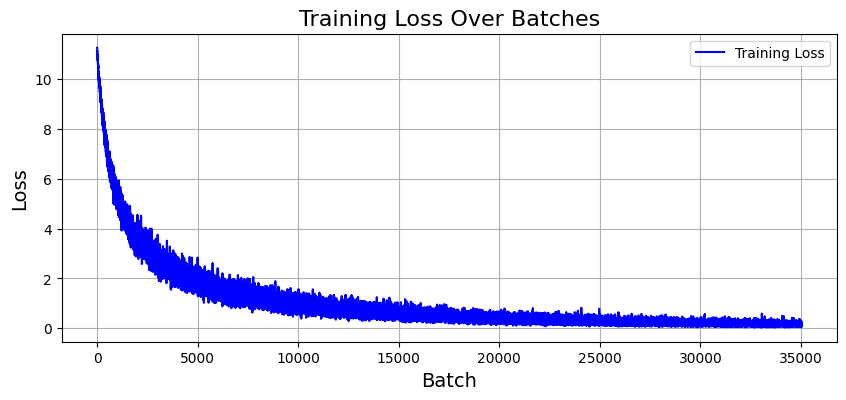

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(losses, label='Training Loss', color='blue')
plt.xlabel('Batch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss Over Batches', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [55]:
checkpoint = {'model': VQAModel(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, '/kaggle/working/model_1.pt')

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [56]:
# def load_checkpoint(filepath):
#     checkpoint = torch.load(filepath)
#     model = checkpoint['model']
#     model.load_state_dict(checkpoint['state_dict'])
#     for parameter in model.parameters():
#         parameter.requires_grad = False
    
#     model.eval()
    
#     return model

# model = load_checkpoint('/kaggle/input/vlsp-cp/vlsp_1b_5p_48m.pt').to(device)

In [57]:
#model.eval()
test_losses = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        anno_id, img_id, images, questions, answers = batch 
        input_answer = ("",)#[" "] * VAL_BATCH_SIZE
        #print(input_answer)
        decoder_input = tokenizer.encode(input_answer, return_tensors="pt", add_special_tokens=False).to(device)
        #print(decoder_input)
        generated_answer = []
        for i in range(MAX_LEN):  
            decoder_input = tokenizer.encode(input_answer, return_tensors="pt", add_special_tokens=False).to(device)
            predicted_tokens, _ = model(images.to(device), questions, input_answer, anno_id, max_len=MAX_LEN, mode='test', mask=False)
            predicted_tokens = predicted_tokens.float()
            #predicted_tokens = F.softmax(predicted_tokens, dim=2) #16 * 48 * 64001
            
            probs, indices = torch.topk(predicted_tokens, k=5, dim=2)
            probs = probs.squeeze()[:i+1, :]
            indices = indices.squeeze()[:i+1, :]
            #print(probs.size(), indices.size())
            if i == 0:
                print("predicted - probabilty")
                for j in range(5):
                    print("'{}' - {:.4f}".format(vocab_swap[indices[:, j][-1].item()], probs[:, j][-1].item()))
            
            predicted_ids = torch.argmax(predicted_tokens, dim=2)[:, :i+1]
            generated_token = tokenizer.decode(predicted_ids[-1])
            generated_answer.append(generated_token)
            input_answer = generated_answer[-1] 
            #print(input_answer)
            decoder_input = predicted_ids.unsqueeze(0).to(device)
            if decoder_input[0,0,-1] == 2: 
                break
            #print(generated_answer)

        print(f"Batch [{batch_idx + 1}/{len(test_loader)}]")
        print(f"Question: {questions[0]}")
        gen_answer = " ".join(generated_answer)
        print(f"Answer Prediction: {gen_answer}")
        print(f"Answer Actual: {answers[0]}")
        if batch_idx == 5:
            break

/tmp/ipykernel_19/2416429134.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = F.softmax(ha)


predicted - probabilty
'<s>' - 15.9484
'loài_người' - 3.0995
'tr' - 2.9043
'búa' - 2.7373
'iết' - 2.7122
Batch [1/56059]
Question: nội_dung trong phần 2 1 đề_cập đến điều gì câu hỏi đặt ra ở đây có ý_nghĩa gì
Answer Prediction: <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> <s> 